In [2]:
%%javascript
console.log("Teste");
require(['notebook/js/codecell'], function(codecell) {
  codecell.CodeCell.options_default.highlight_modes['text/x-rustsrc'] = {'reg':[/^%%prov/]} ;
  Jupyter.notebook.events.one('kernel_ready.Kernel', function(){
  Jupyter.notebook.get_cells().map(function(cell){
      if (cell.cell_type == 'code'){ cell.auto_highlight(); } }) ;
  });
});


<IPython.core.display.Javascript object>

In [3]:
from IPython.core.magic import Magics, magics_class, cell_magic
from IPython.core.magic_arguments import  magic_arguments, argument, parse_argstring
from IPython.display import Image

@magics_class
class ProvMagic(Magics):
    
    @cell_magic
    def prov(self, line, cell):
        path = line.split(" ", 1)[-1]
        result = self.shell.run_cell_magic("provn", f"-o {path} -e pdf svg provn dot -s paper4", cell)
        self.shell.system(f"inkscape -f {path}.svg -e {path}.png -d 300")
        return Image(f"{path}.png")
get_ipython().register_magics(ProvMagic)

In [4]:
%reload_ext extensible_provn.prov_magics
import extensible_provn.view.versioned_prov
BASE = "../generated/presentation"

# Versioned-PROV: A PROV extension to support mutable data entities

Authors:
- João Felipe Pimentel
- Paolo Missier
- Leonardo Murta
- Vanessa Braganholo

# PROV

- Entensible model
- Domain-agnostic
  - Operating Systems
  - Workflow Systems
  - Scripts
  - ...
 
![PROV key concepts overview. The figure shows an entity, an agent, and an activity](https://www.w3.org/TR/2013/NOTE-prov-primer-20130430/images/key-concepts.png)
Image from PROV Model Primer
https://www.w3.org/TR/2013/NOTE-prov-primer-20130430/
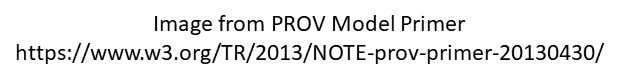

# PROV for Scripts

- Existing approaches describe coarse-grained provenance

```python
i = 534
j = 237
k = 789
min(i, j, k)
```

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:532:401.333 exported to 1662 x 1254 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/call.png


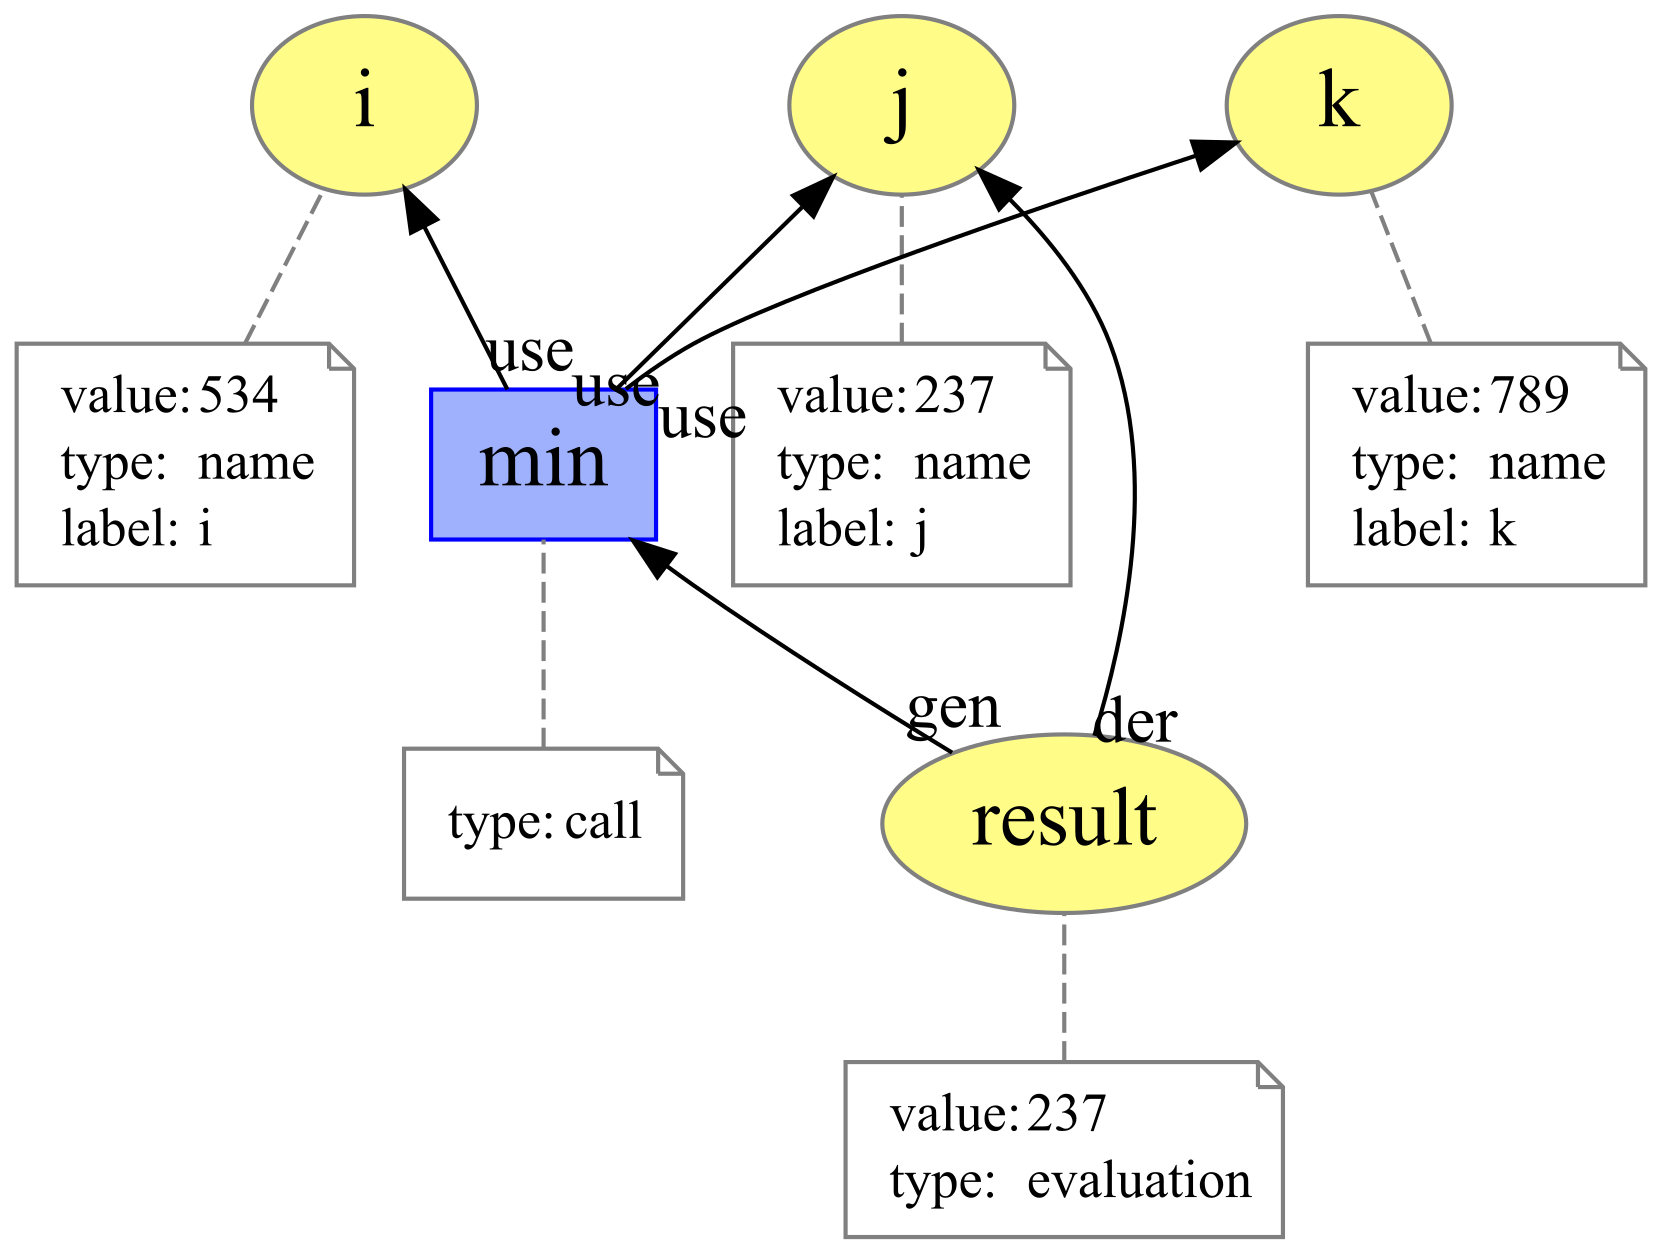

In [5]:
%%prov $BASE/call
entity(i, [value="534", type="script:name", label="i"])
entity(j, [value="237", type="script:name", label="j"])
entity(k, [value="789", type="script:name", label="k"])

entity(result, [value="237", type="script:evaluation"])
activity(min, [type="script:call"])
wasDerivedFrom(result, j, min, g1, u1)
wasGeneratedBy(g1; result, min)
used(u1; min, j, [dot:dist="0"])
used(min, i)
used(min, k, [dot:dist="2"])

# Fine-Grained Provenance

- Assignment

```python
m = 10000
```

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:348:401.333 exported to 1087 x 1254 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/assign.png


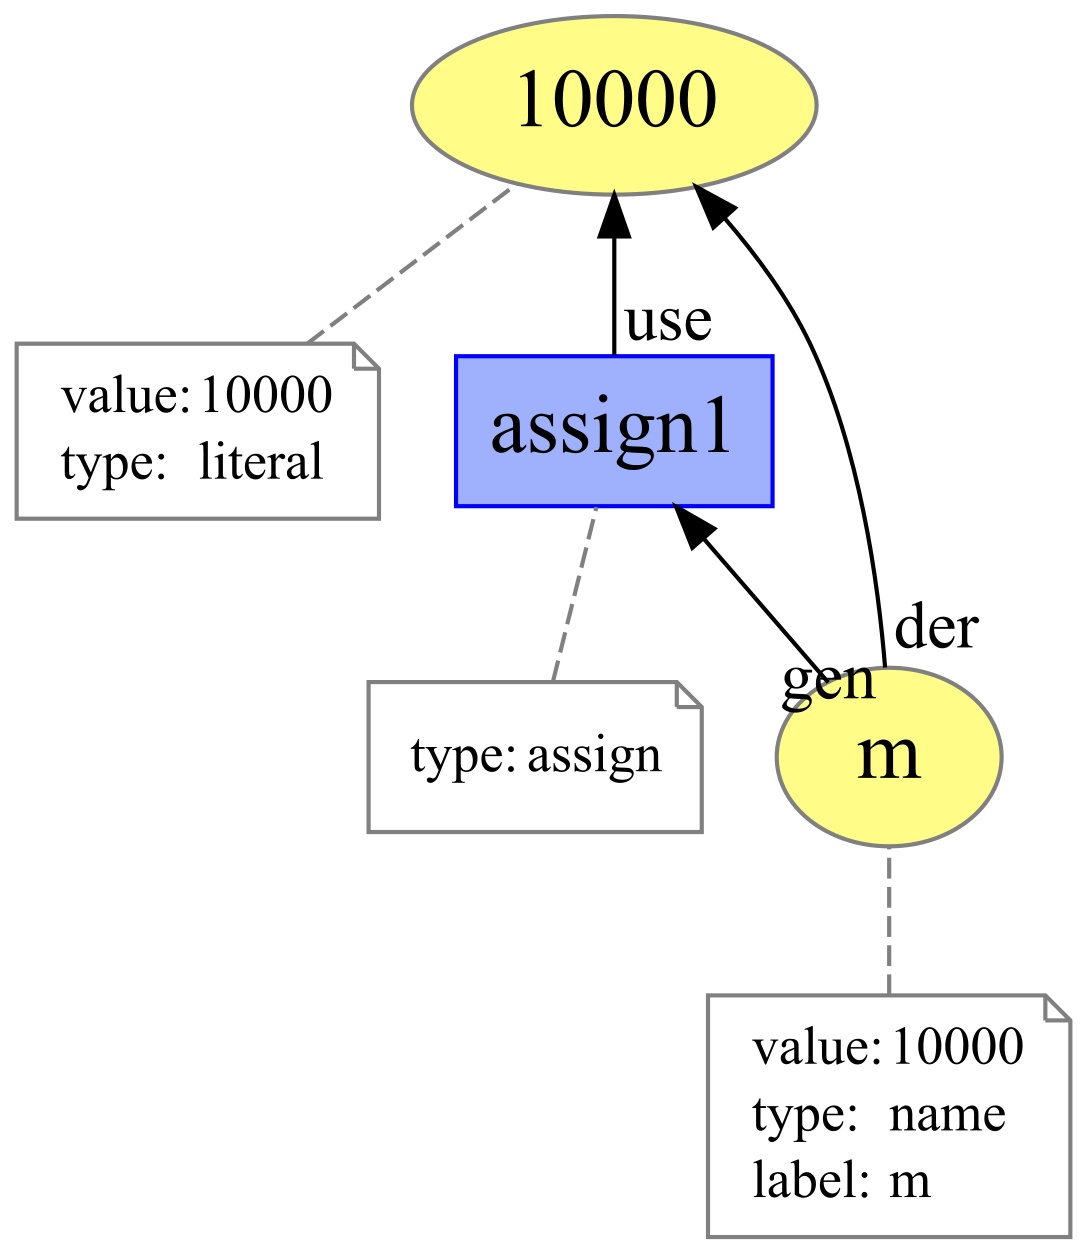

In [6]:
%%prov $BASE/assign
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>
    
entity(10000, [value="10000", type="script:literal"])
entity(m, [value="10000", type="script:name", label="m"])

activity(assign1, [type="script:assign"])
wasDerivedFrom(m, 10000, assign1, -, u1, [dot:dist="1.5"])
wasGeneratedBy(g1; m, assign1, [dot:dist="0"])
used(u1; assign1, 10000, [dot:dist="1.5"])

# Challenges

- PROV entities are immutable
- Two main problems

# P1

When an assignment to a collection entity occurs, the new entity should have all the members of the original entity.

- N `hadMember` statements

```python
a = [2, 6, 0]

b = a
```

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:472:636 exported to 1475 x 1987 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/p1.png


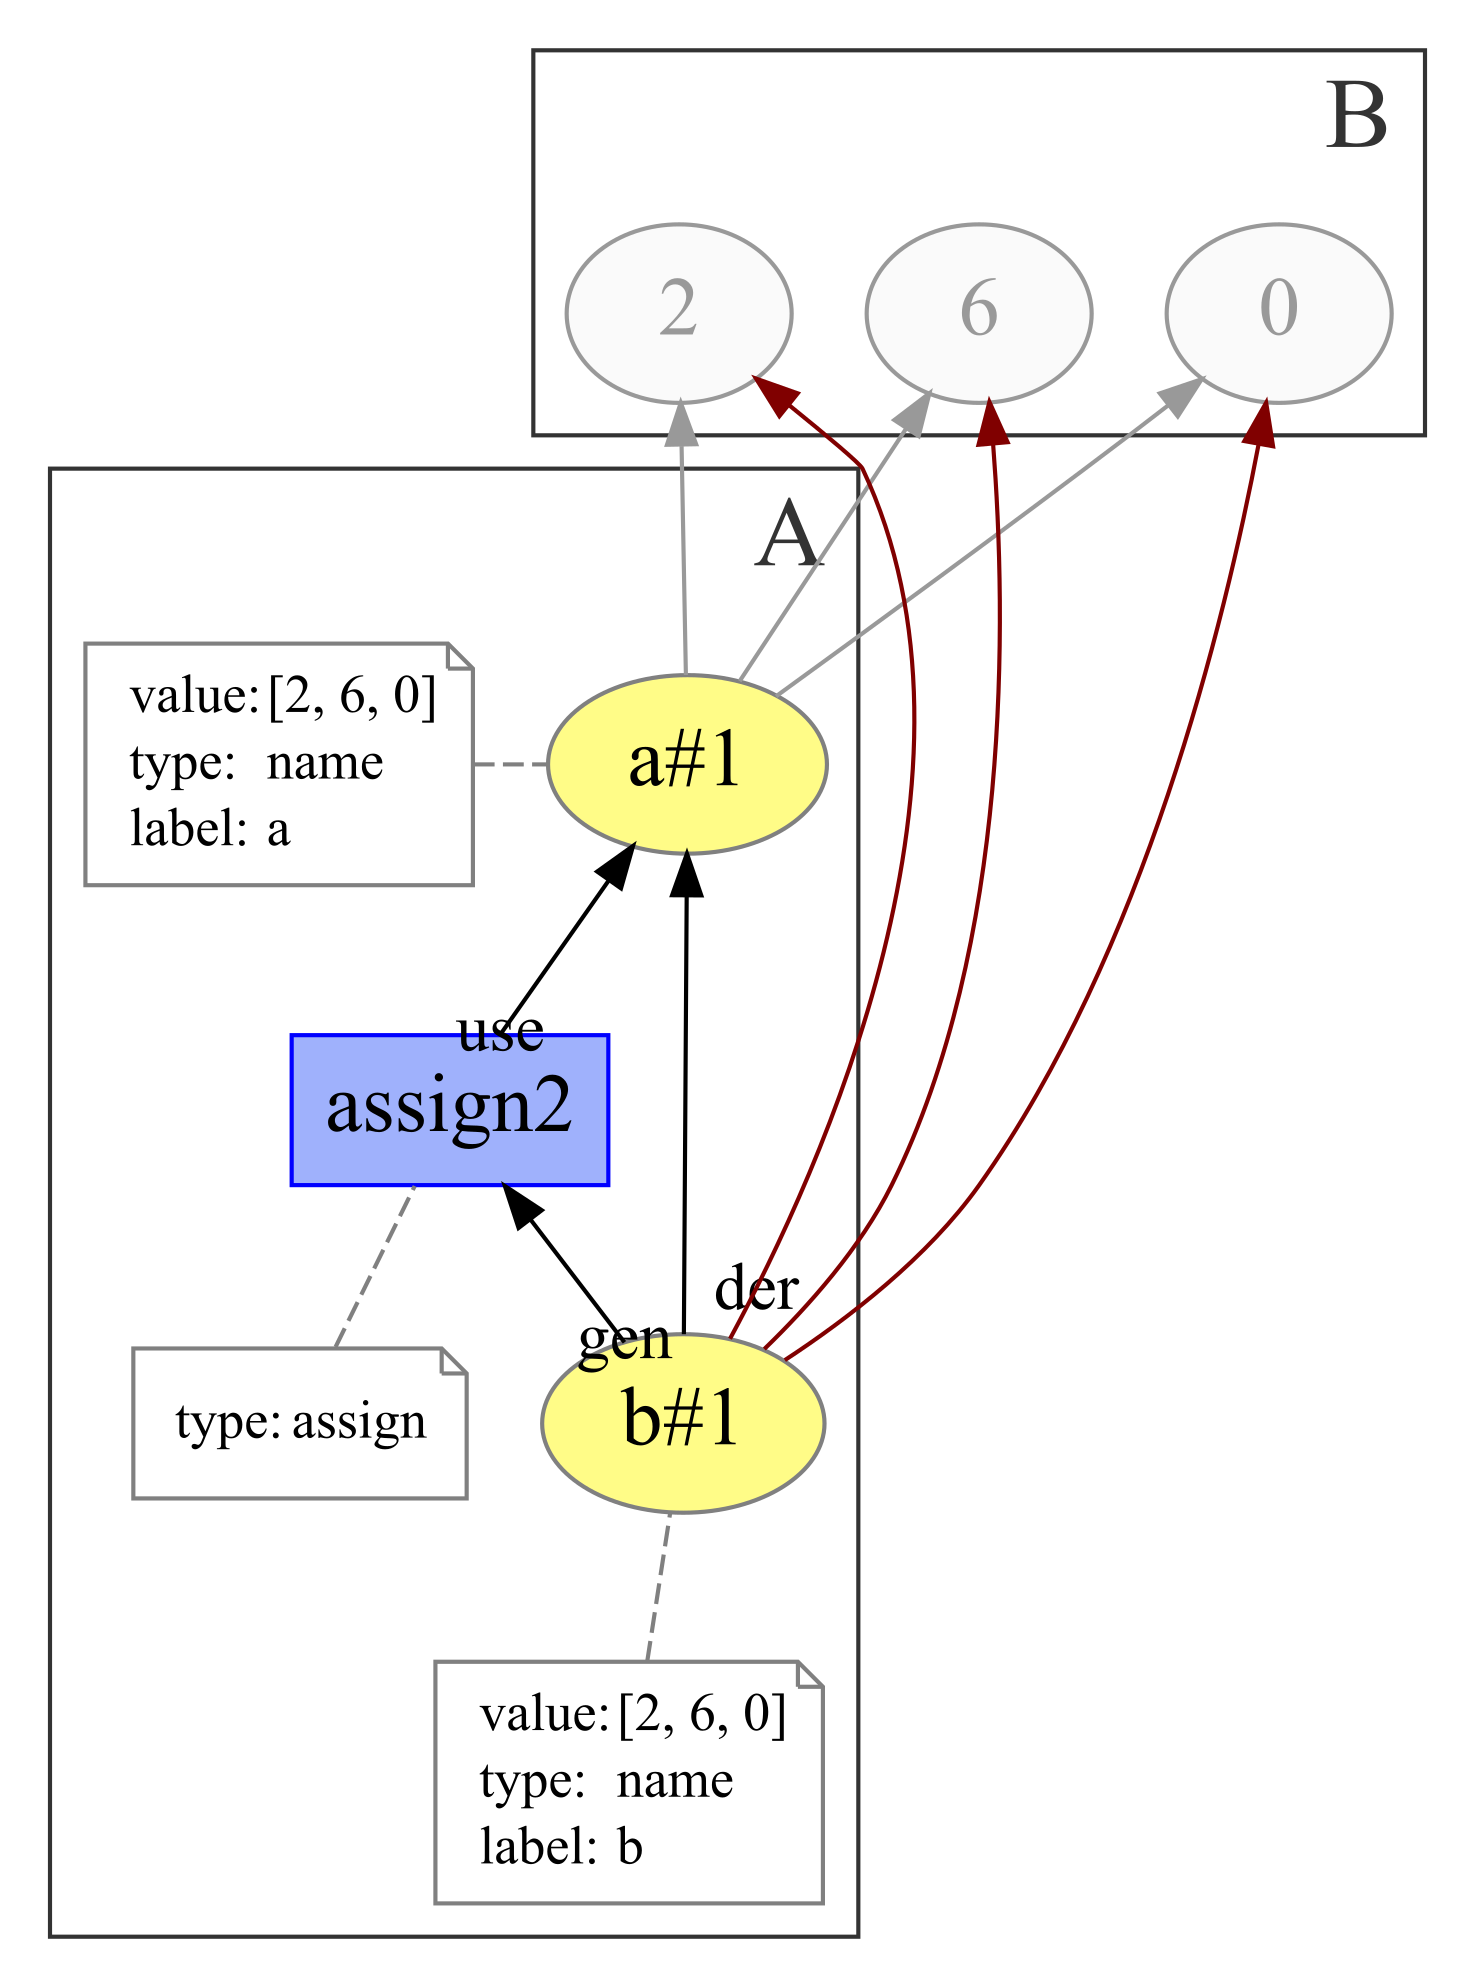

In [7]:
%%prov $BASE/p1
newrank=true;
splines = "spline"

subgraph cluster_0 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "A";
    "g/a#1";
    "g/b#1"; "g/assign2"
    "g/a#1-attrs";
    "g/b#1-attrs"; "g/assign2-attrs"
    
}
subgraph cluster_1 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "B";
    "g/2"; "g/6";  "g/0"; 
}
##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>


entity(2, [value="2", type="script:literal", dot:hide2="true"])
entity(6, [value="6", type="script:literal", dot:hide2="true"])
entity(0, [value="0", type="script:literal", dot:hide2="true"])

entity(a#1, [value="[2, 6, 0]", type="script:name", label="a"])
entity(b#1, [value="[2, 6, 0]", type="script:name", label="b"])

hadMember(a#1, 2, [dot:hide2="true"])
hadMember(a#1, 6, [dot:hide2="true"])
hadMember(a#1, 0, [dot:hide2="true"])

hadMember(b#1, 2, [dot:specific="true"])
hadMember(b#1, 6, [dot:specific="true"])
hadMember(b#1, 0, [dot:specific="true"])

activity(assign2, [type="script:assign"])
wasDerivedFrom(b#1, a#1, assign2, u2, g2, [dot:dist="2"])
used(u2; assign2, a#1, -, [dot:dist="0"])
wasGeneratedBy(g2; b#1, assign2, -, [dot:dist="0"])
endDocument
##F##
{rank=same "g/a#1" "g/a#1-attrs"}
{rank=same "g/2" "g/6" "g/0"}
"g/0" -> "g/6" -> "g/2" [style=invis]


# P2-simplified

When an entity that represents a collection is changed, a new entity should be created, together with multiple new relationships.

- 1 `entity` + 2 `wasDerivedFrom` + N `hadMember` = 3 + N statements

```python
a = [2, 6, 0]

a[1] = 3
```

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:857.333:733.333 exported to 2679 x 2292 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/p2simple.png


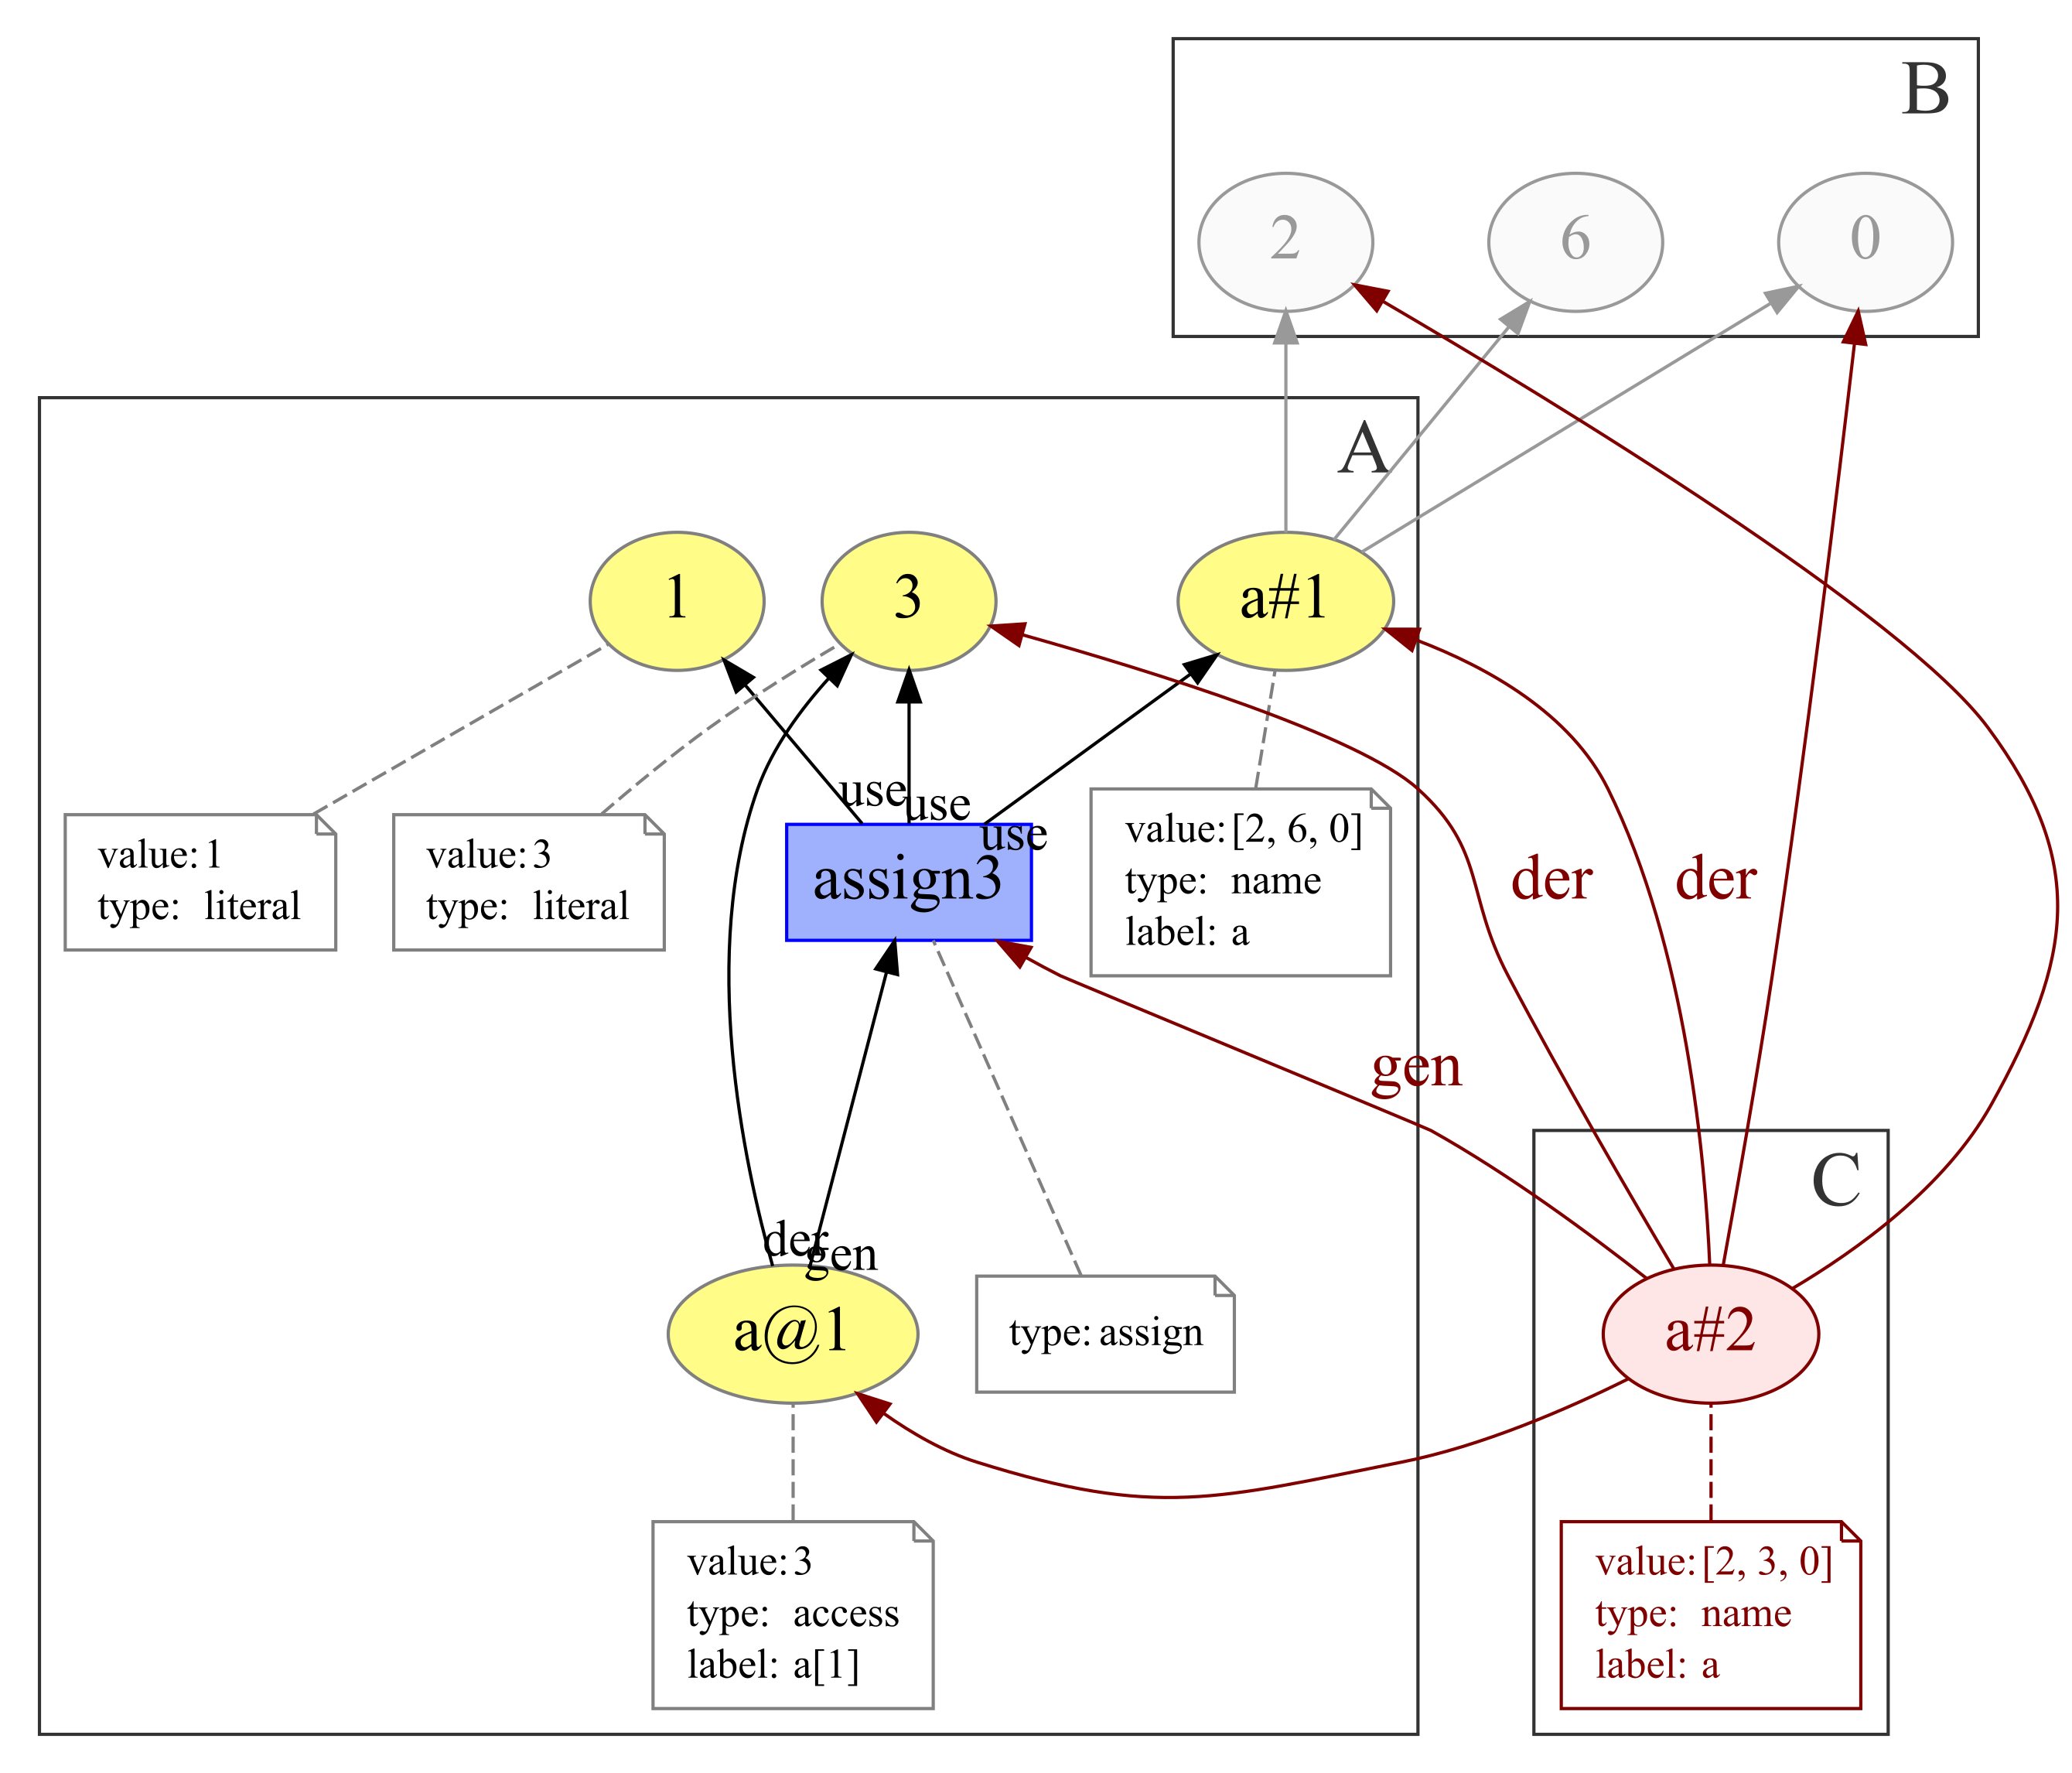

In [8]:
%%prov $BASE/p2simple
newrank=true;
splines = "spline"

subgraph cluster_0 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "A";
    "g/a@1"; "g/1"; "g/3"
    "g/a#1"; "g/assign3"
    "g/a@1-attrs"; "g/1-attrs"; "g/3-attrs"
    "g/a#1-attrs"; "g/assign3-attrs"
    
}
subgraph cluster_1 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "B";
    "g/0"; "g/6"; "g/2";
}

subgraph cluster_2 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "C";
    "g/a#2"; "g/a#2-attrs" 
}
##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>

entity(2, [value="2", type="script:literal", dot:hide2="true"])
entity(6, [value="6", type="script:literal", dot:hide2="true"])
entity(0, [value="0", type="script:literal", dot:hide2="true"])

entity(3, [value="3", type="script:literal"])
entity(1, [value="1", type="script:literal"])
entity(a#2, [value="[2, 3, 0]", type="script:name", label="a", dot:specific="true"])
entity(a#1, [value="[2, 6, 0]", type="script:name", label="a"])

entity(a@1, [value="3", type="script:access", label="a[1]"])
       
hadMember(a#1, 2, [dot:hide2="true"])
hadMember(a#1, 6, [dot:hide2="true"])
hadMember(a#1, 0, [dot:hide2="true"])

hadMember(a#2, 2, [dot:specific="true"])
hadMember(a#2, a@1, [dot:specific="true"])
hadMember(a#2, 0, [dot:specific="true"])

activity(assign3, [type="script:assign"])
wasDerivedFrom(a#2, a#1, assign3, g3, u3, [dot:specific="true"])
used(u3; assign3, a#1, -)
wasDerivedFrom(a#2, 3, assign3, g3, u4, [dot:specific="true"])
wasDerivedFrom(a@1, 3, assign3, g4, u4)
used(assign3, 1, -)
endDocument
##F##
{rank=same "g/2" "g/6" "g/0"}
{rank=same "g/a@1" "g/a#2"}
"g/0" -> "g/6" -> "g/2" [style=invis]
"g/1" -> "g/2" [style=invis]
"g/a#2" -> "g/6" [style=invis]


# P2

When more than one variable is assigned to the same collection, and one of the variables changes, all other variables should also change, as they refer to the same memory area.

- 3 + N statements **for each** reference

```python
a = [2, 6, 0]
b = a

a[1] = 3
```

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:1037.33:817.333 exported to 3242 x 2554 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/p2.png


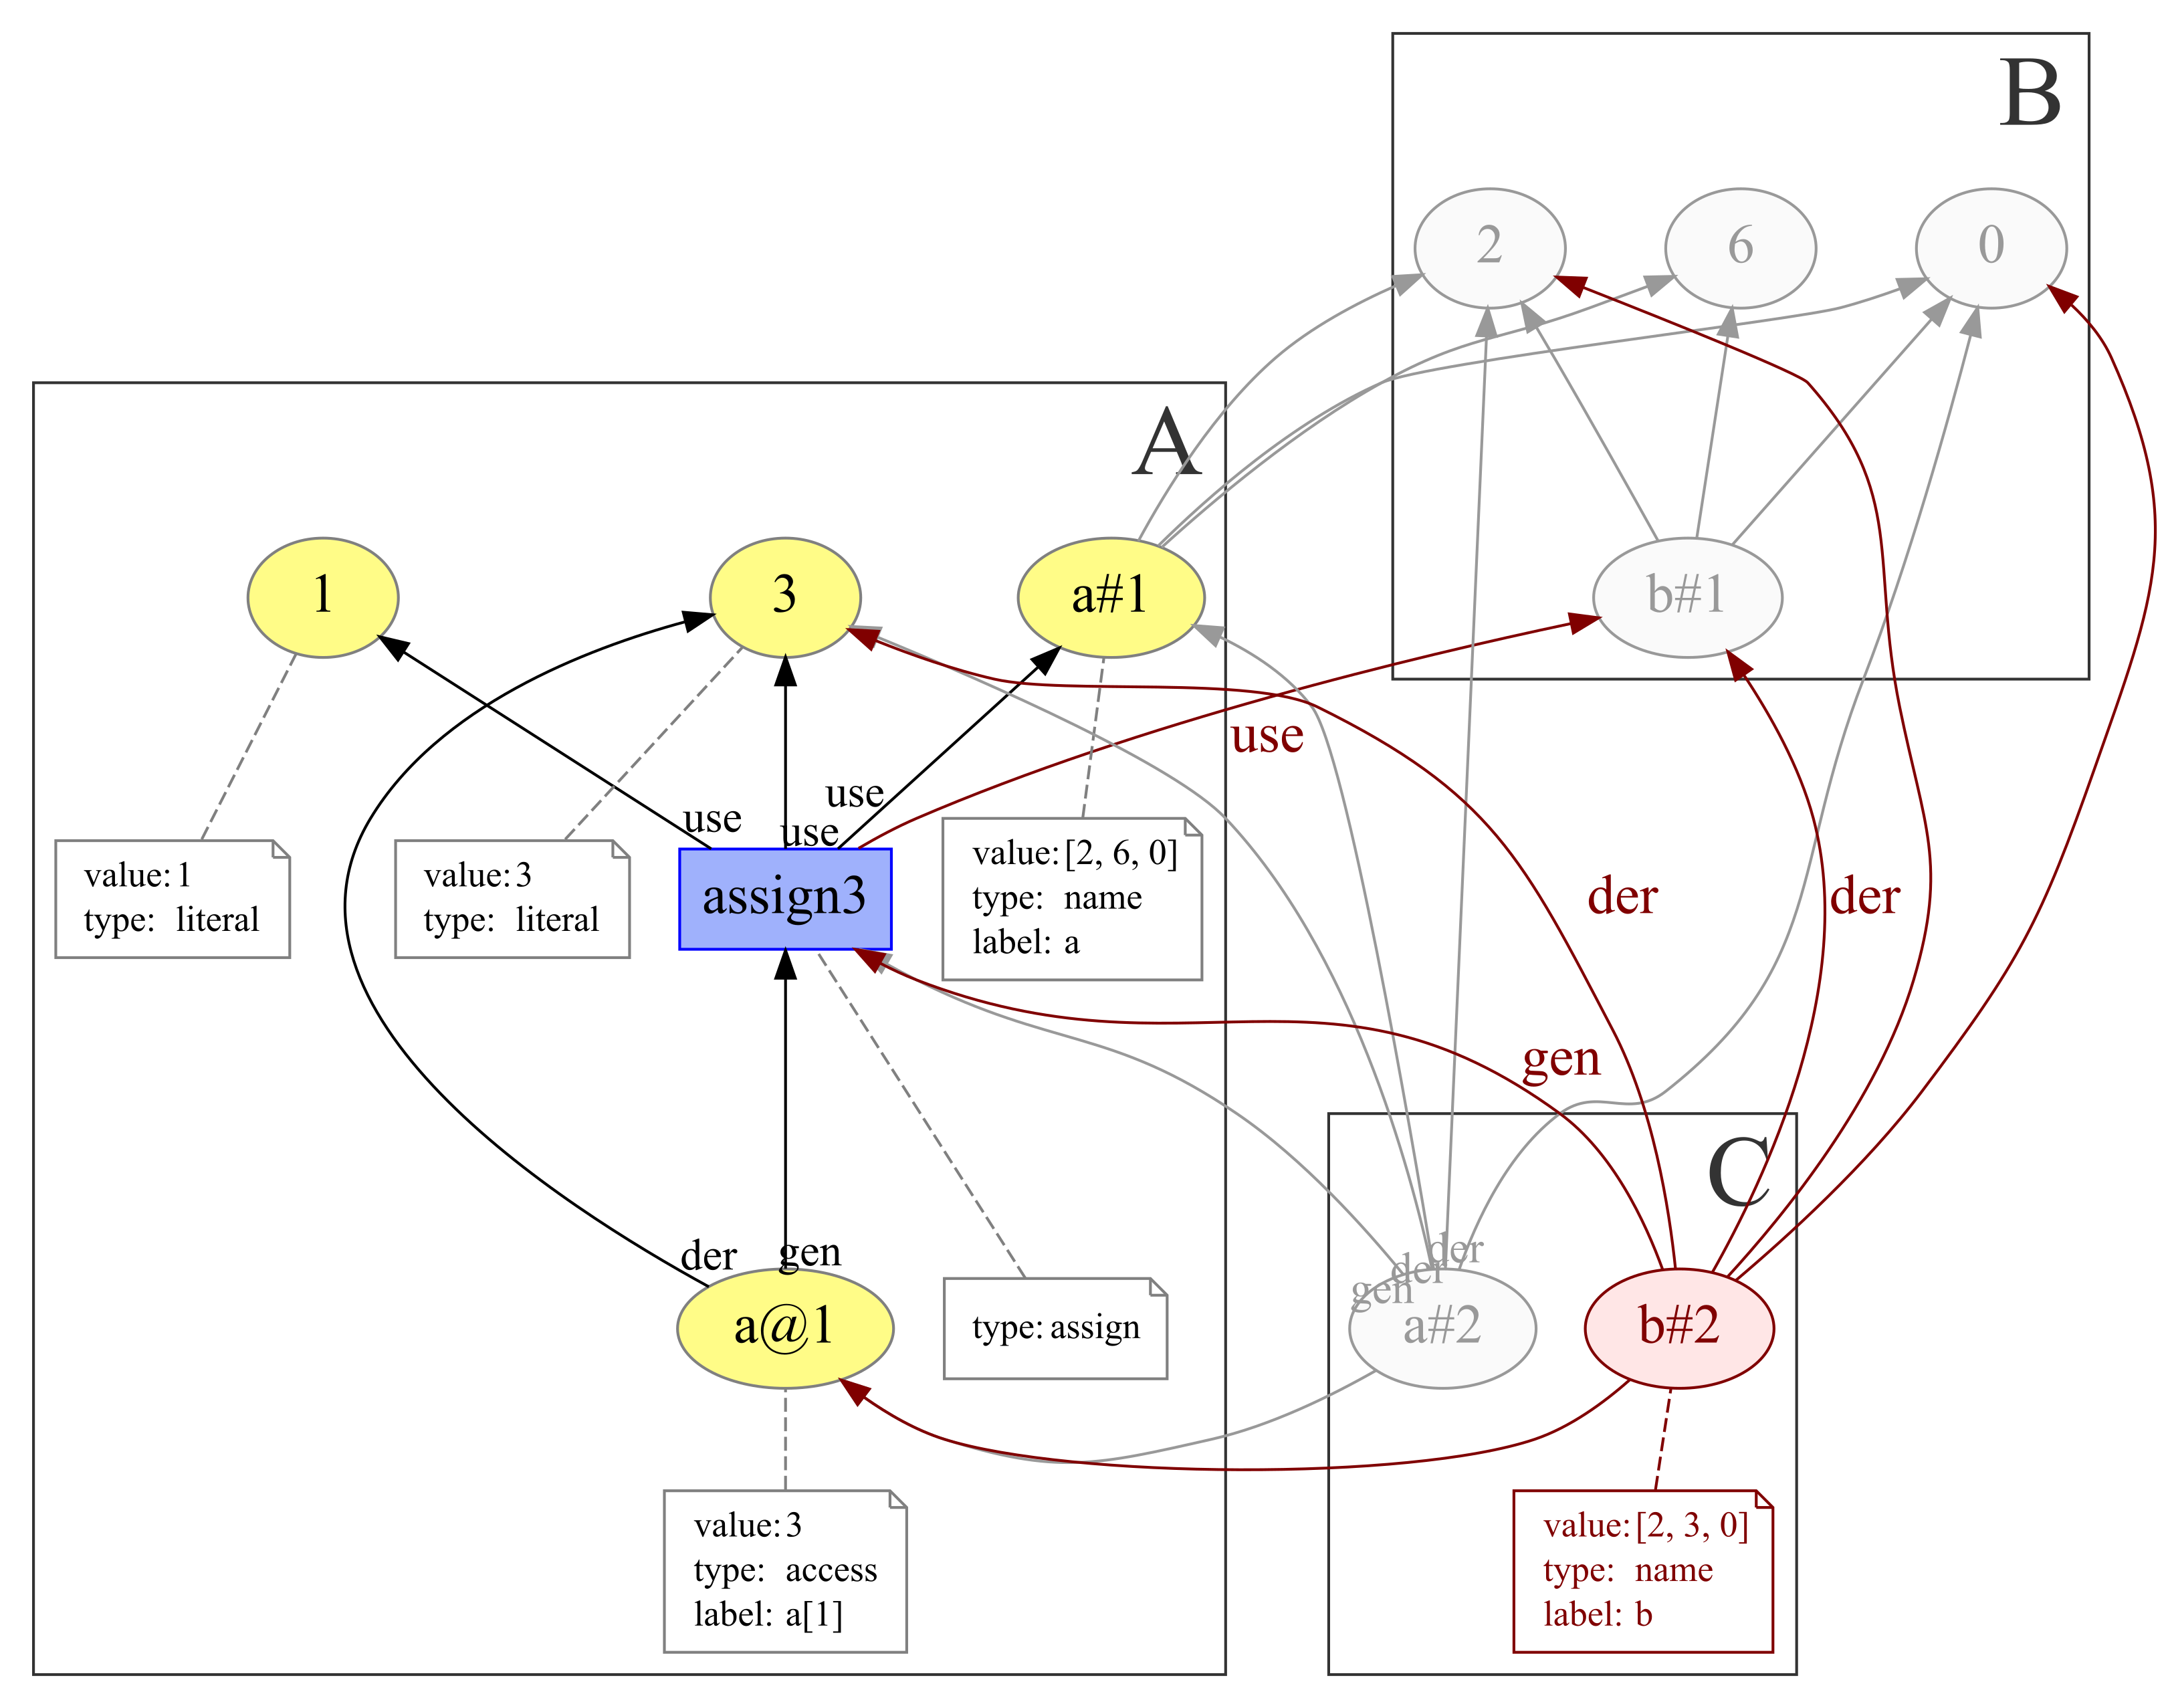

In [9]:
%%prov $BASE/p2
newrank=true;
splines = "spline"

subgraph cluster_0 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "36"
    label = "A";
    "g/a@1"; "g/1"; "g/3"
    "g/a#1"; "g/assign3"
    
    "g/a@1-attrs"; "g/1-attrs"; "g/3-attrs"
    "g/a#1-attrs"; "g/assign3-attrs"
    
    
}
subgraph cluster_1 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "36"
    label = "B";
    "g/2"; "g/6"; "g/0"; "g/b#1";
}

subgraph cluster_2 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "36"
    label = "C";
    "g/a#2";
    "g/b#2"; "g/b#2-attrs" 
}

##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>


entity(2, [value="2", type="script:literal", dot:hide2="true"])
entity(6, [value="6", type="script:literal", dot:hide2="true"])
entity(0, [value="0", type="script:literal", dot:hide2="true"])
entity(a#1, [value="[2, 6, 0]", type="script:name", label="a"])
entity(b#1, [value="[2, 6, 0]", type="script:name", label="b", dot:hide2="true"])
entity(3, [value="3", type="script:literal"])
entity(1, [value="1", type="script:literal"])
entity(a#2, [value="[2, 3, 0]", type="script:name", label="a", dot:hide2="true"])
entity(b#2, [value="[2, 3, 0]", type="script:name", label="b", dot:specific="true"])

       
       
entity(a@1, [value="3", type="script:access", label="a[1]"])
       
hadMember(a#1, 2, [dot:hide2="true"])
hadMember(a#1, 6, [dot:hide2="true"])
hadMember(a#1, 0, [dot:hide2="true"])
          
hadMember(b#1, 2, [dot:hide2="true"])
hadMember(b#1, 6, [dot:hide2="true"])
hadMember(b#1, 0, [dot:hide2="true"])

hadMember(a#2, 2, [dot:hide2="true"])
hadMember(a#2, a@1, [dot:hide2="true"])
hadMember(a#2, 0, [dot:hide2="true"])

hadMember(b#2, 2, [dot:specific="true"])
hadMember(b#2, a@1, [dot:specific="true"])
hadMember(b#2, 0, [dot:specific="true"])

          
activity(assign3, [type="script:assign"])
wasDerivedFrom(a#2, a#1, assign3, g4, u4, [dot:hide2="true"])
wasDerivedFrom(a#2, 3, assign3, g4, u4, [dot:hide2="true", dot:dist="0.5", dot:angle="270.0"])
used(u4; assign3, a#1, -, [dot:dist="2", dot:angle="-30.0"])
wasGeneratedBy(g4; a#2, assign3, -, [dot:hide2="true", dot:dist="1", dot:angle="270.0"])
wasDerivedFrom(b#2, b#1, assign3, g6, u6, [dot:specific="true"])
wasDerivedFrom(b#2, 3, assign3, g6, u5, [dot:specific="true"])
wasDerivedFrom(a@1, 3, assign3, g5, u5)

used(assign3, 1, -)
endDocument
##F##
{rank=same "g/2" "g/6" "g/0"}
{rank=same "g/a@1" "g/a#2" "g/b#2"}
//{rank=same "g/a#1" "g/a#1-attrs"}
{rank=same "g/1" "g/3"}
"g/0" -> "g/6" -> "g/2" [style=invis]
"g/1" -> "g/2" [style=invis]
//"g/2" -> "g/3" [style=invis]
"g/a#2" -> "g/6" [style=invis]
//"g/b#2" -> "g/6" [style=invis]


# Challenges

- PROV entities are immutable
- Two main problems
  - P1: $O(N)$ new elements in collection assignments
  - P2: $\Omega(R\times N)$ new elements in collection changes
- N: number of elements
- R: number of variables referring to the same collection

# Goal

Reduce the storage overhead in collection assignments and changes to 𝑂(1)

# Versioned-PROV

- PROV extension
  - Checkpoints, Reference Sharing, Accesses
- An entity may represent multiple versions of a data object
  - Checkpoints identify these versions

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:533.333:308 exported to 1667 x 962 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/versioned.png


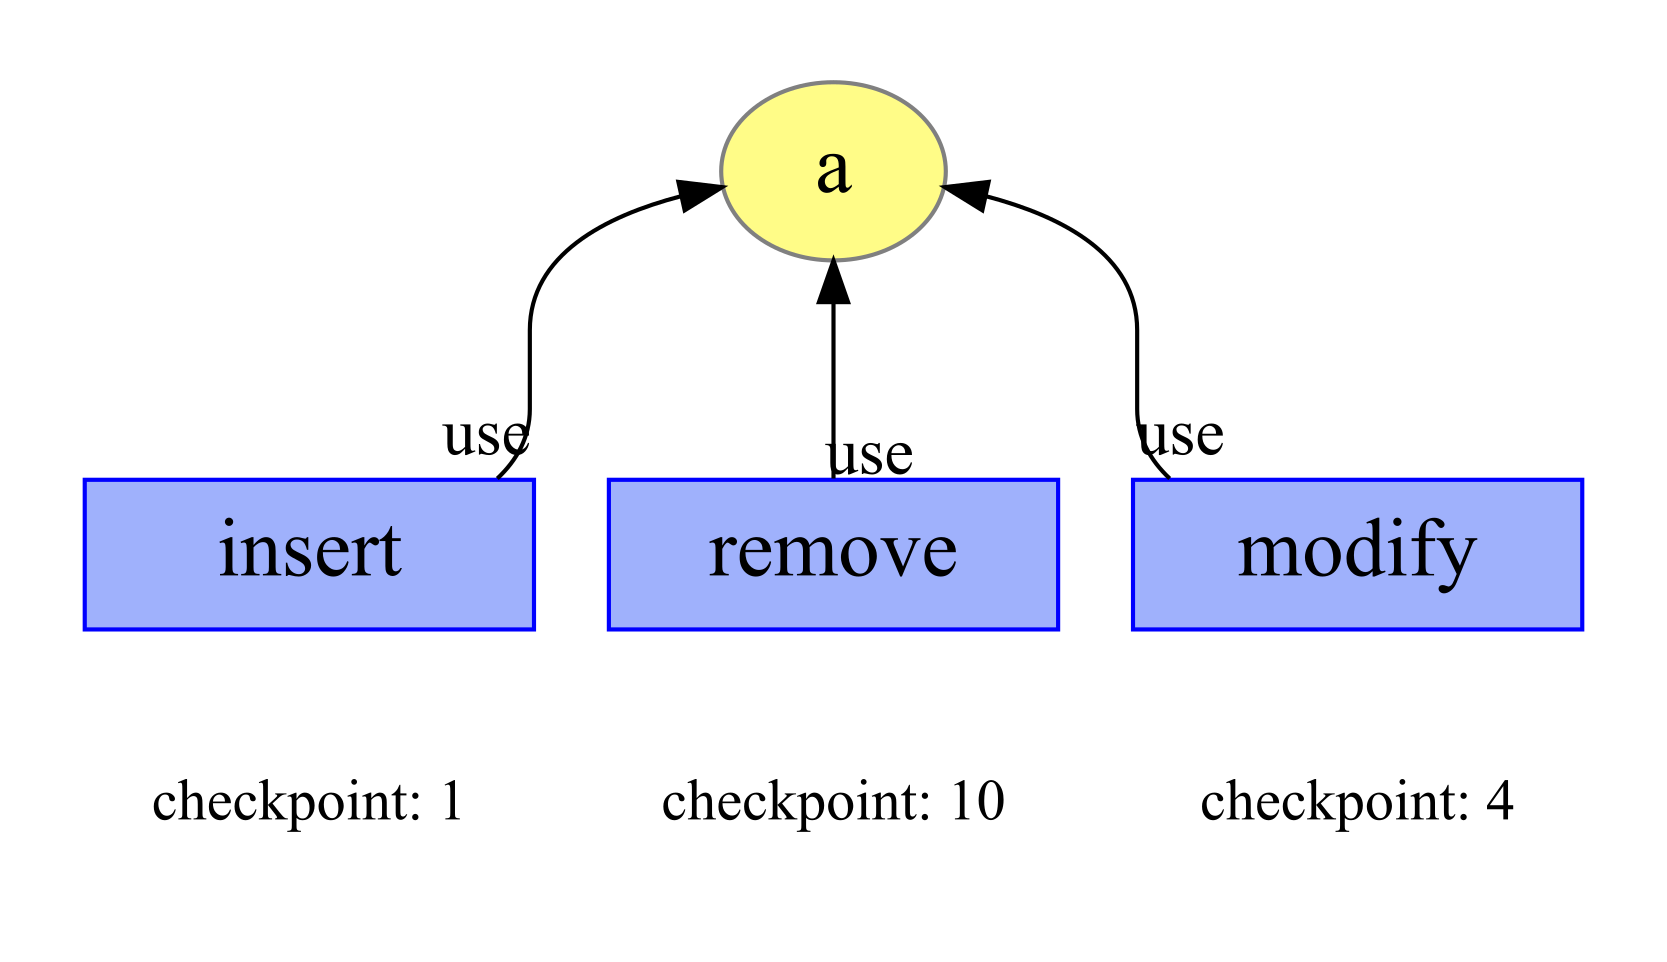

In [10]:
%%prov $BASE/versioned
ranksep=0.1; 

subgraph cluster_1 {
    color=white
    "g/modify" [shape=box color=white fixedsize=true width=1.5]
    "g/remove" [shape=box color=white fixedsize=true width=1.5]
    "g/insert" [shape=box color=white fixedsize=true width=1.5]

    edge [minlen=6]
##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>

entity(a)
activity(insert)
activity(remove)
activity(modify)
used(insert, a, [dot:dist="1", dot:angle="-60"])
used(remove, a)
used(modify, a)
endDocument
##F##
}

subgraph cluster_0 {
    color=white
    node [shape=box color=white fixedsize=true width=1.5]
    chk1 [label="checkpoint: 1" ]
    chk10 [label="checkpoint: 10"]
    chk4 [label="checkpoint: 4" ]
    chk1 -> "g/insert" [style=invis]
    chk10 -> "g/remove" [style=invis]
    chk4 -> "g/modify" [style=invis]
}

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:850.667:125.333 exported to 2658 x 392 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/timeline.png


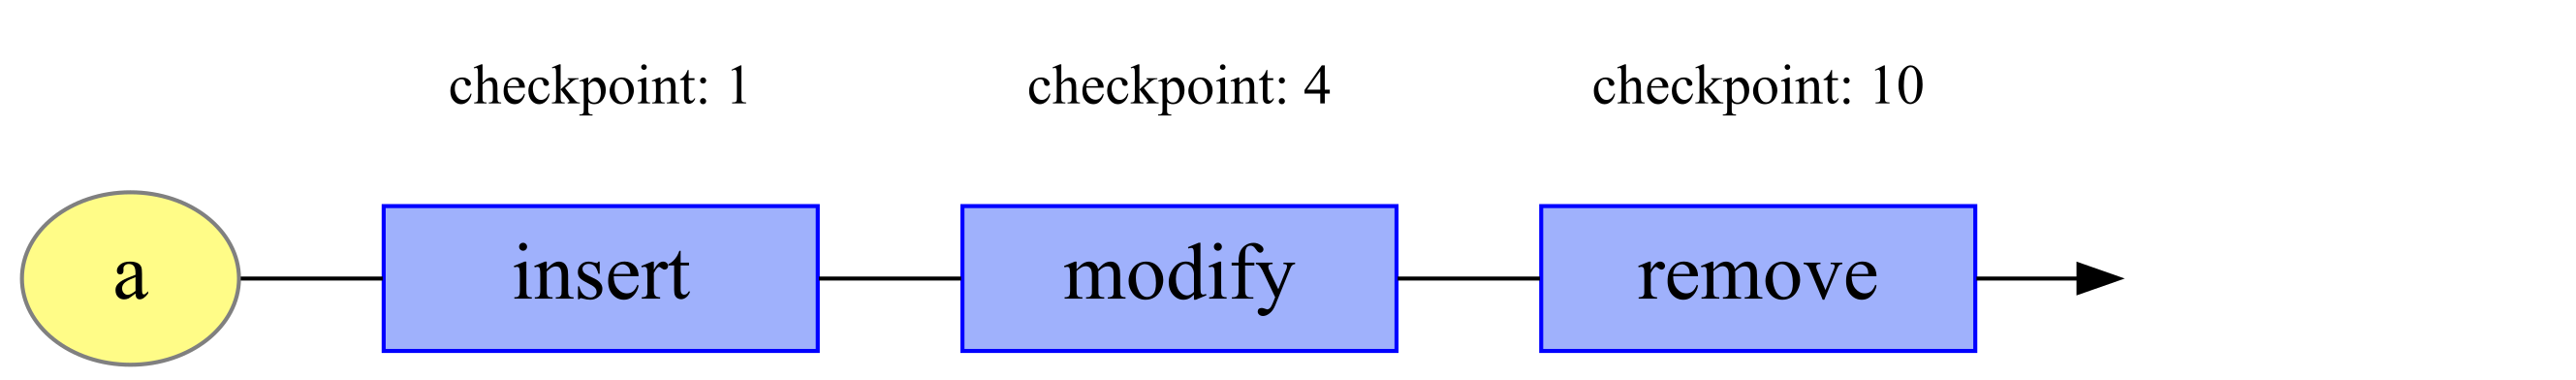

In [11]:
%%prov $BASE/timeline
ranksep=0.05
color=white
"g/modify" [shape=box color=white fixedsize=true width=1.5]
"g/remove" [shape=box color=white fixedsize=true width=1.5]
"g/insert" [shape=box color=white fixedsize=true width=1.5]
edge [minlen=2]
##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>

entity(a)
activity(insert)
activity(remove)
activity(modify)
endDocument
##F##

    color=white
    node [shape=box color=white fixedsize=true width=1.5]
    chk1 [label="checkpoint: 1" ]
    chk10 [label="checkpoint: 10"]
    chk4 [label="checkpoint: 4" ]
    "g/insert" -> chk1  [style=invis minlen=1]
    "g/remove" -> chk10 [style=invis minlen=1]
    "g/modify" -> chk4  [style=invis minlen=1]
    
    "g/a" -> "g/insert" -> "g/modify" -> "g/remove" [arrowhead=none]
    end [label="" shape=box color=white fixedsize=true width=1.5]
    "g/remove" -> end

    
{rank=same "g/a" "g/insert"  "g/modify"  "g/remove" end}

# PROV Constraint

- Unique-generation constraint:
  - A PROV entity can only be generated once
- Versioned-PROV follows PROV semantics
  - Mutability occurs only in collection entities
  - A Versioned-PROV collection may have different **members** at different moments

# Incremental Membership

Source
```python
a = [2,6,0]
a.append(4) # insert 
a[1] = 3    # modify
a.pop()     # remove
```

Modify operation
```Rust
hadMember(a, 3, [type="version:Put", version:key="1", version:checkpoint="4"])
```

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:657.333:225.333 exported to 2054 x 704 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/incremental.png


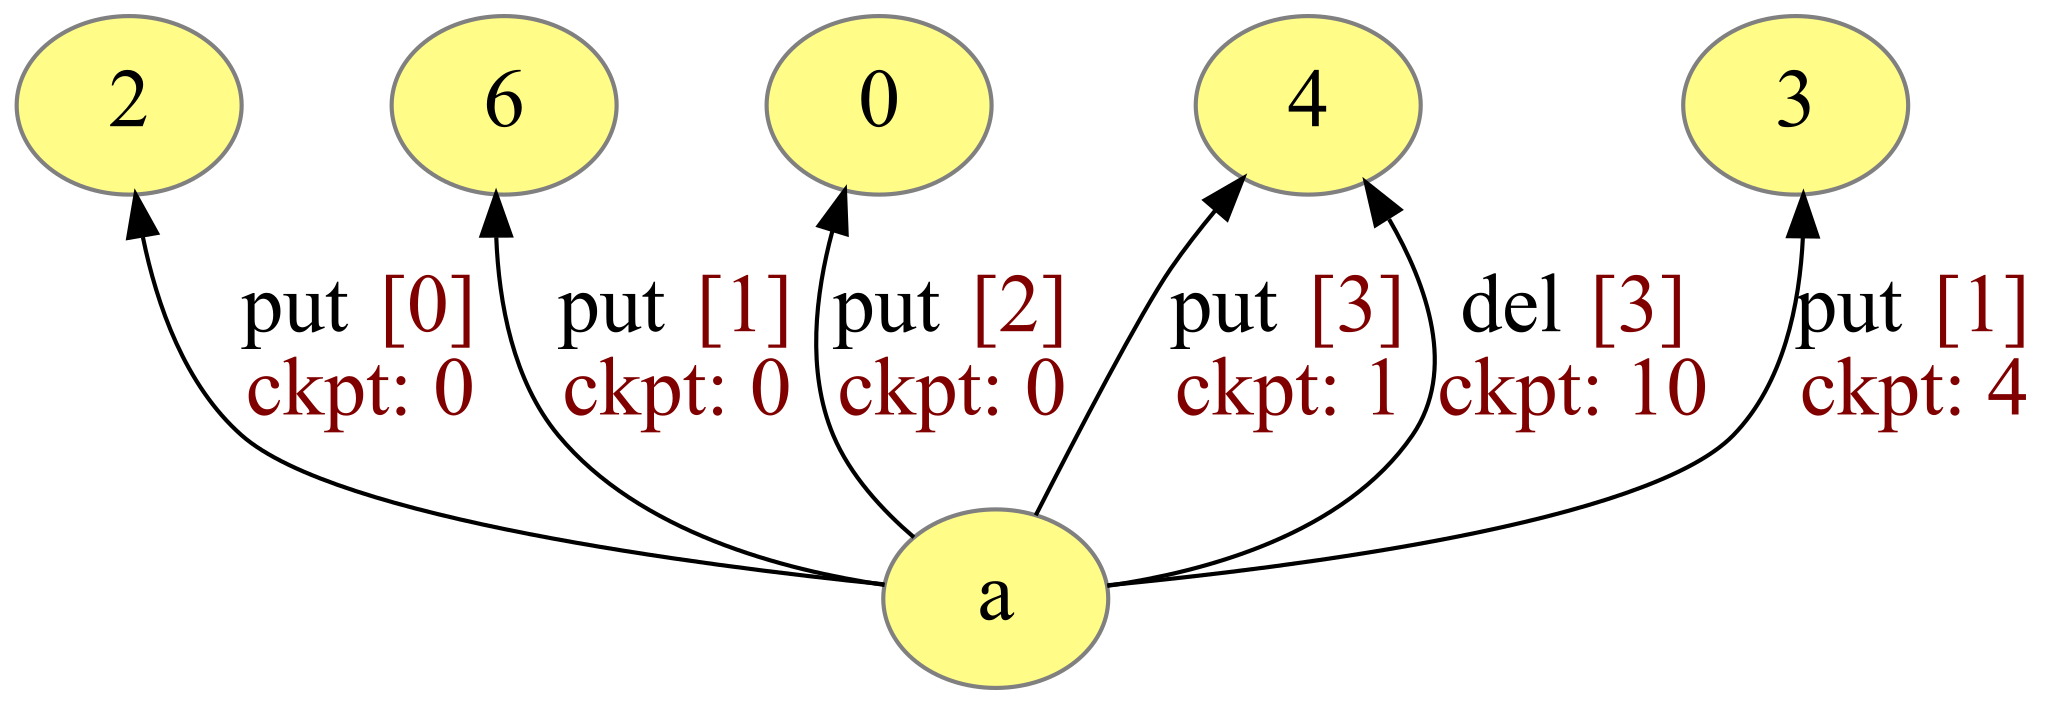

In [12]:
%%prov $BASE/incremental
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>


entity(6, [value="6", type="script:literal", dot:hide3="true"])
entity(2, [value="2", type="script:literal", dot:hide3="true"])
entity(0, [value="0", type="script:literal", dot:hide3="true"])
entity(4, [value="4", type="script:literal", dot:hide3="true"])
entity(3, [value="3", type="script:literal", dot:hide3="true"])
entity(a, [value="[2, 6, 0]", type="script:list", label="[2, 6, 0]", dot:hide3="true"])
hadMember(a, 2, [type="version:Put", version:key="0", version:checkpoint="0"])
hadMember(a, 6, [type="version:Put", version:key="1", version:checkpoint="0"])
hadMember(a, 0, [type="version:Put", version:key="2", version:checkpoint="0"])
hadMember(a, 4, [type="version:Put", version:key="3", version:checkpoint="1"])
hadMember(a, 3, [type="version:Put", version:key="1", version:checkpoint="4"])
hadMember(a, 4, [type="version:Del", version:key="3", version:checkpoint="10"])

endDocument
##F##
"g/2"->"g/6"->"g/0"->"g/4"->"g/3" [style=invis]
{rank=same "g/2" "g/6" "g/0" "g/3" "g/4" }


# Events

- Events associated to Versioned-PROV entities should indicate the checkpoint
  - used(u1; a1, e1, t1, [version:checkpoint="c1"])
  - wasGeneratedBy(g1; e2, a1, t2, [version:checkpoint="c2"])
  - wasDerivedFrom(e2, e1, a1, g1, u1, [version:checkpoint="c3"])
    - Derivation occurs after use: 𝑐1<𝑐3
    - Derivation may occur during generation: c2≤𝑐3 


# P1 Revisited

(P1) When an assignment to a collection entity occurs, Versioned-PROV does not recreate the
membership.

```python
a = [2,6,0]

b = a
```

PROV-N
```Rust
wasDerivedFrom(
  b, a, assign2, 
  g1, u1, [
    type="version:Reference",
    version:checkpoint="1"
])
```

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:428:724 exported to 1337 x 2262 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/versioned_p1.png


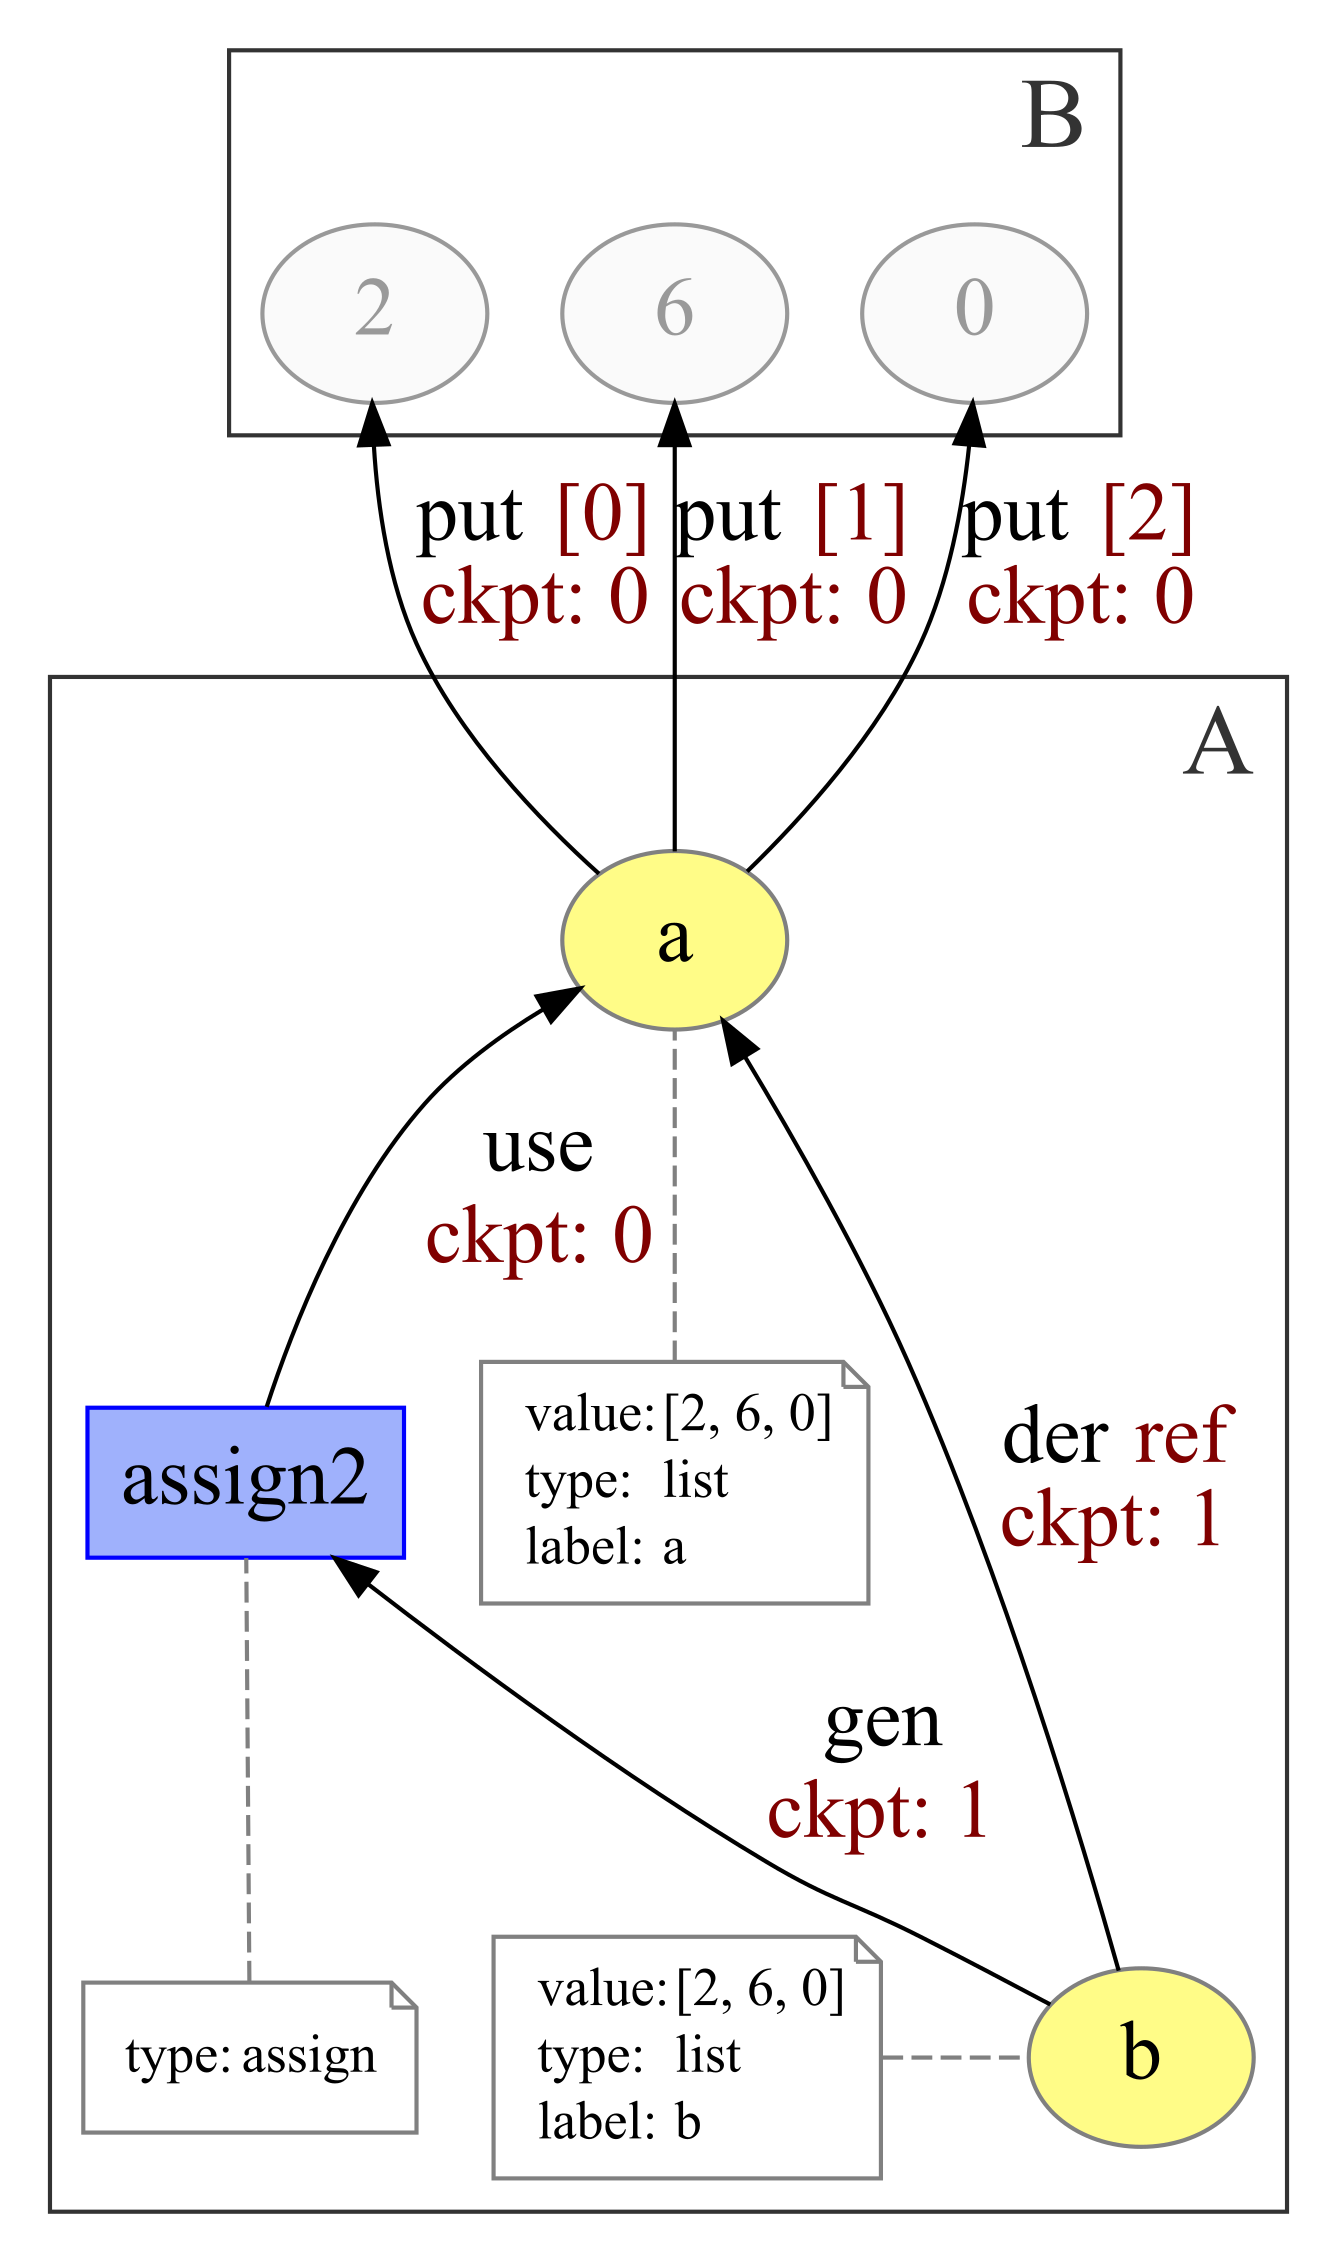

In [13]:
%%prov $BASE/versioned_p1
newrank=true;
splines = "spline"

subgraph cluster_0 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "A";
    "g/a";
    "g/b"; "g/assign2"
    "g/a-attrs";
    "g/b-attrs"; "g/assign2-attrs"
    
}
subgraph cluster_1 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "B";
    "g/2"; "g/6";  "g/0"; 
}
##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>

entity(6, [value="6", type="script:literal", dot:hide2="true"])
entity(2, [value="2", type="script:literal", dot:hide2="true"])
entity(0, [value="0", type="script:literal", dot:hide2="true"])
entity(a, [value="[2, 6, 0]", type="script:list", label="a"])
hadMember(a, 2, [type="version:Put", version:key="0", version:checkpoint="0"])
hadMember(a, 6, [type="version:Put", version:key="1", version:checkpoint="0"])
hadMember(a, 0, [type="version:Put", version:key="2", version:checkpoint="0"])
entity(b, [value="[2, 6, 0]", type="script:list", label="b"])

activity(assign2, [type="script:assign"])
wasDerivedFrom(b, a, assign2, g1, u1, [type="version:Reference", version:checkpoint="1"])
used(u1; assign2, a, [version:checkpoint="0"])
endDocument
##F##
{rank=same "g/b" "g/b-attrs"}

# P2 Revisited

When an entity that represents a collection changes, Versioned-PROV does not create new collection entities.

```python
0: a = [2,6,0]
1: b = a

4: a[1] = 3
```

PROV-N
```Rust
wasDerivedFrom(a@1, 3, assign3, g5, u5, [type="version:Reference", version:checkpoint="4", version:collection="a", version:key="1", version:access="w"])
```

- b derives by reference
- Access Representation

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:656:850.667 exported to 2050 x 2658 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/versioned_p2.png


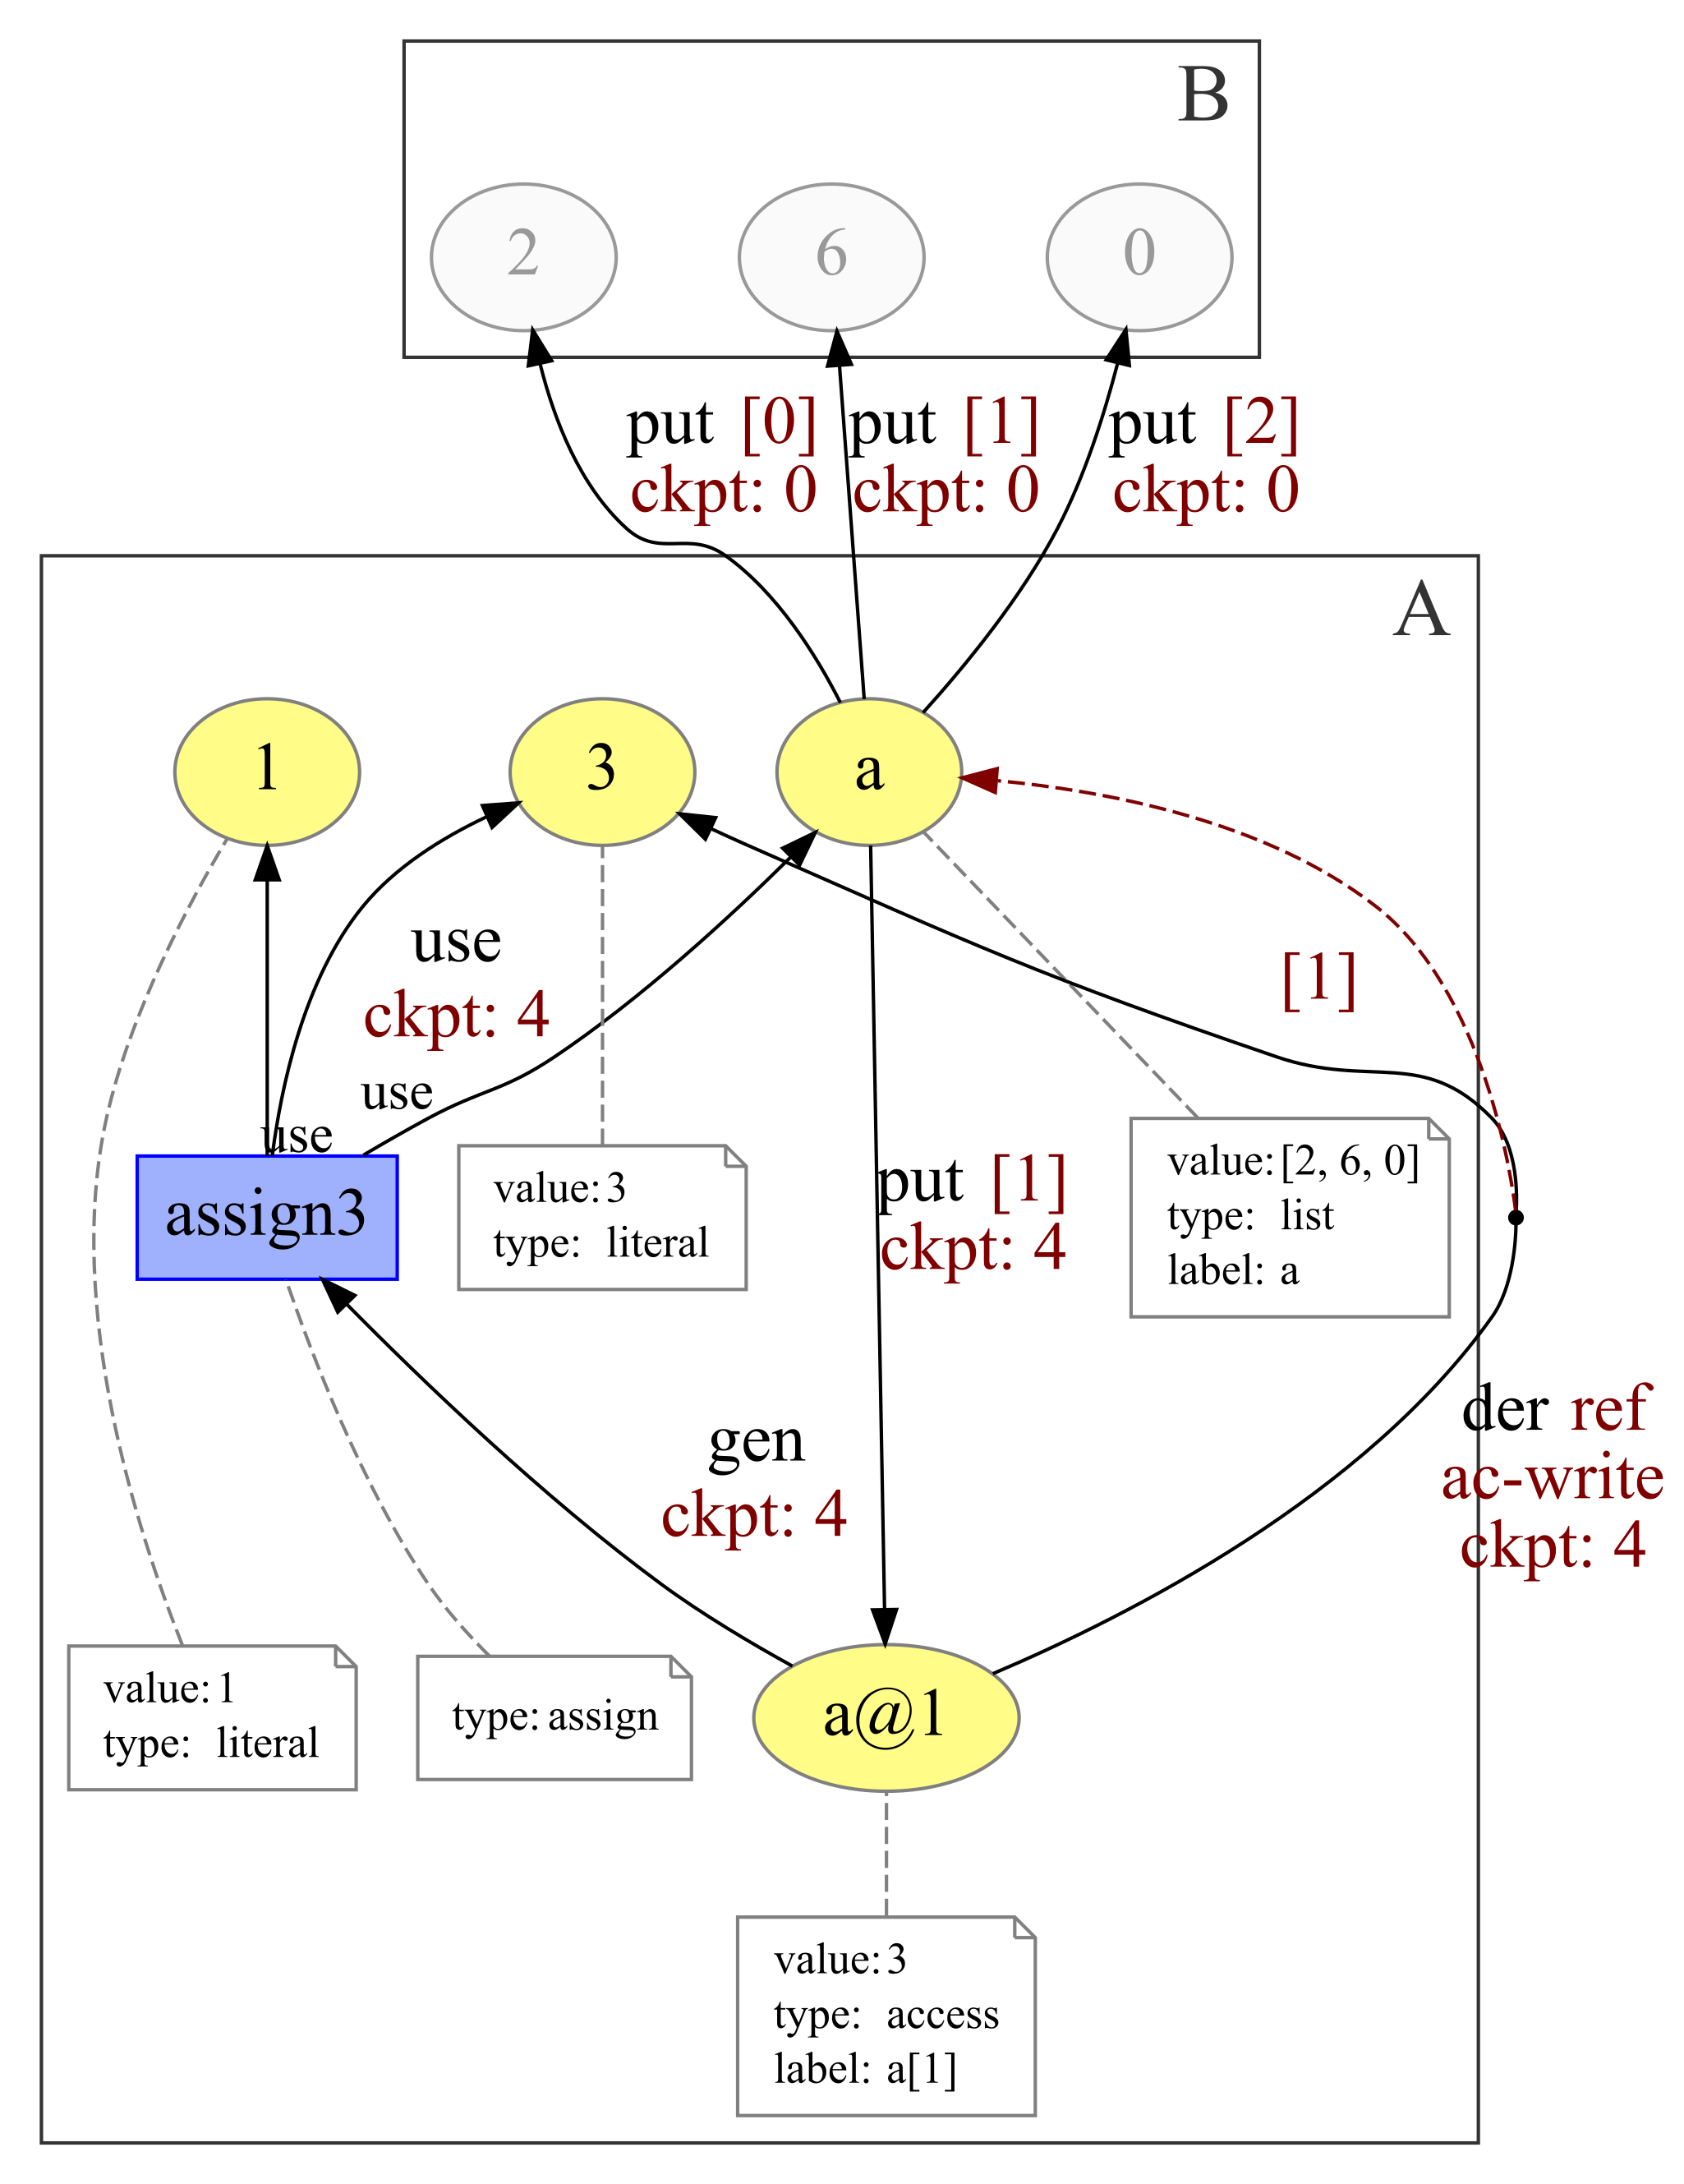

In [14]:
%%prov $BASE/versioned_p2
newrank=true;
splines = "spline"

subgraph cluster_0 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "A";
    "g/a@1"; "g/1"; "g/3"
    "g/a"; "g/assign3"
    
    "g/a@1-attrs"; "g/1-attrs"; "g/3-attrs"
    "g/a-attrs"; "g/assign3-attrs"
    
    
}
subgraph cluster_1 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "B";
    "g/2"; "g/6"; "g/0"; 
}

##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>


entity(6, [value="6", type="script:literal", dot:hide2="true"])
entity(2, [value="2", type="script:literal", dot:hide2="true"])
entity(0, [value="0", type="script:literal", dot:hide2="true"])
entity(a, [value="[2, 6, 0]", type="script:list", label="a"])
entity(a@1, [value="3", type="script:access", label="a[1]"])
hadMember(a, 2, [type="version:Put", version:key="0", version:checkpoint="0"])
hadMember(a, 6, [type="version:Put", version:key="1", version:checkpoint="0"])
hadMember(a, 0, [type="version:Put", version:key="2", version:checkpoint="0"])
hadMember(a, a@1, [type="version:Put", version:key="1", version:checkpoint="4"])
entity(3, [value="3", type="script:literal"])
entity(1, [value="1", type="script:literal"])

          
activity(assign3, [type="script:assign"])
used(u4; assign3, a, -, [dot:dist="2", dot:angle="-30.0"])
wasDerivedFrom(a@1, 3, assign3, g5, u5, [type="version:Reference", version:checkpoint="4", version:collection="a", version:key="1", version:access="w"])
used(assign3, 1, -)

endDocument
##F##
{rank=same "g/2" "g/6" "g/0"}
{rank=same "g/1" "g/3"}
{rank=same "g/1-attrs" "g/assign3-attrs"}
"g/0" -> "g/6" -> "g/2" [style=invis]
"g/1" -> "g/2" [style=invis]


# Related Work

- PROV-Dictionary extension
  - Adds Insertion and Removal derivations to PROV
  - Reduces the storage 
  - Still assumes entity immutability
    - High overhead in comparison to Versioned-PROV
- Most of the other PROV extensions are domain specific
  - Do not improve the PROV support for data structures

- StarFlow and Tariq et al. (2012) export provenance from scripts to OPM
  - Coarse-grained provenance with no data structures
- RDataTracker, noWorkflow, CXXR collect fine grained provenance
  - Use non-interoperable formats
  - Statement level provenance with no support to data structure changes
- Michaelides et al. (2016) collect provenance from Blockly variables and export it to plain PROV
  - 𝑂(𝑁) collection assignments, Ω(𝑁×𝑅) collection changes

# Evaluation

https://dew-uff.github.io/versioned-prov/comparison.html

# Conclusion

# Limitations

- Introduces overhead for querying
  - Reconstruct versions
- Dictionary-like structure to represent lists
  - Indexes mapped to keys
  - Inserting an element at the beginning of the list requires the shift of most elements
- Optional PROV-N attributes
  - Overhead in disk due to name repetition
- Parallelism
  - Hard to keep total checkpoint order


# Future Work

- Unfolding algorithm
  - Convert Versioned-PROV into plain PROV
- Efficient querying algorithm for Versioned-PROV
- Incremental membership definition of lists
  - Add operation for adding elements and shifting them without explicit Put operations
- Adopt the proposed model in noWorkflow


# PROV-Dictionary

In [15]:
import extensible_provn.view.prov_dictionary

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:629.333:844 exported to 1967 x 2637 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/dictionary_p1.png


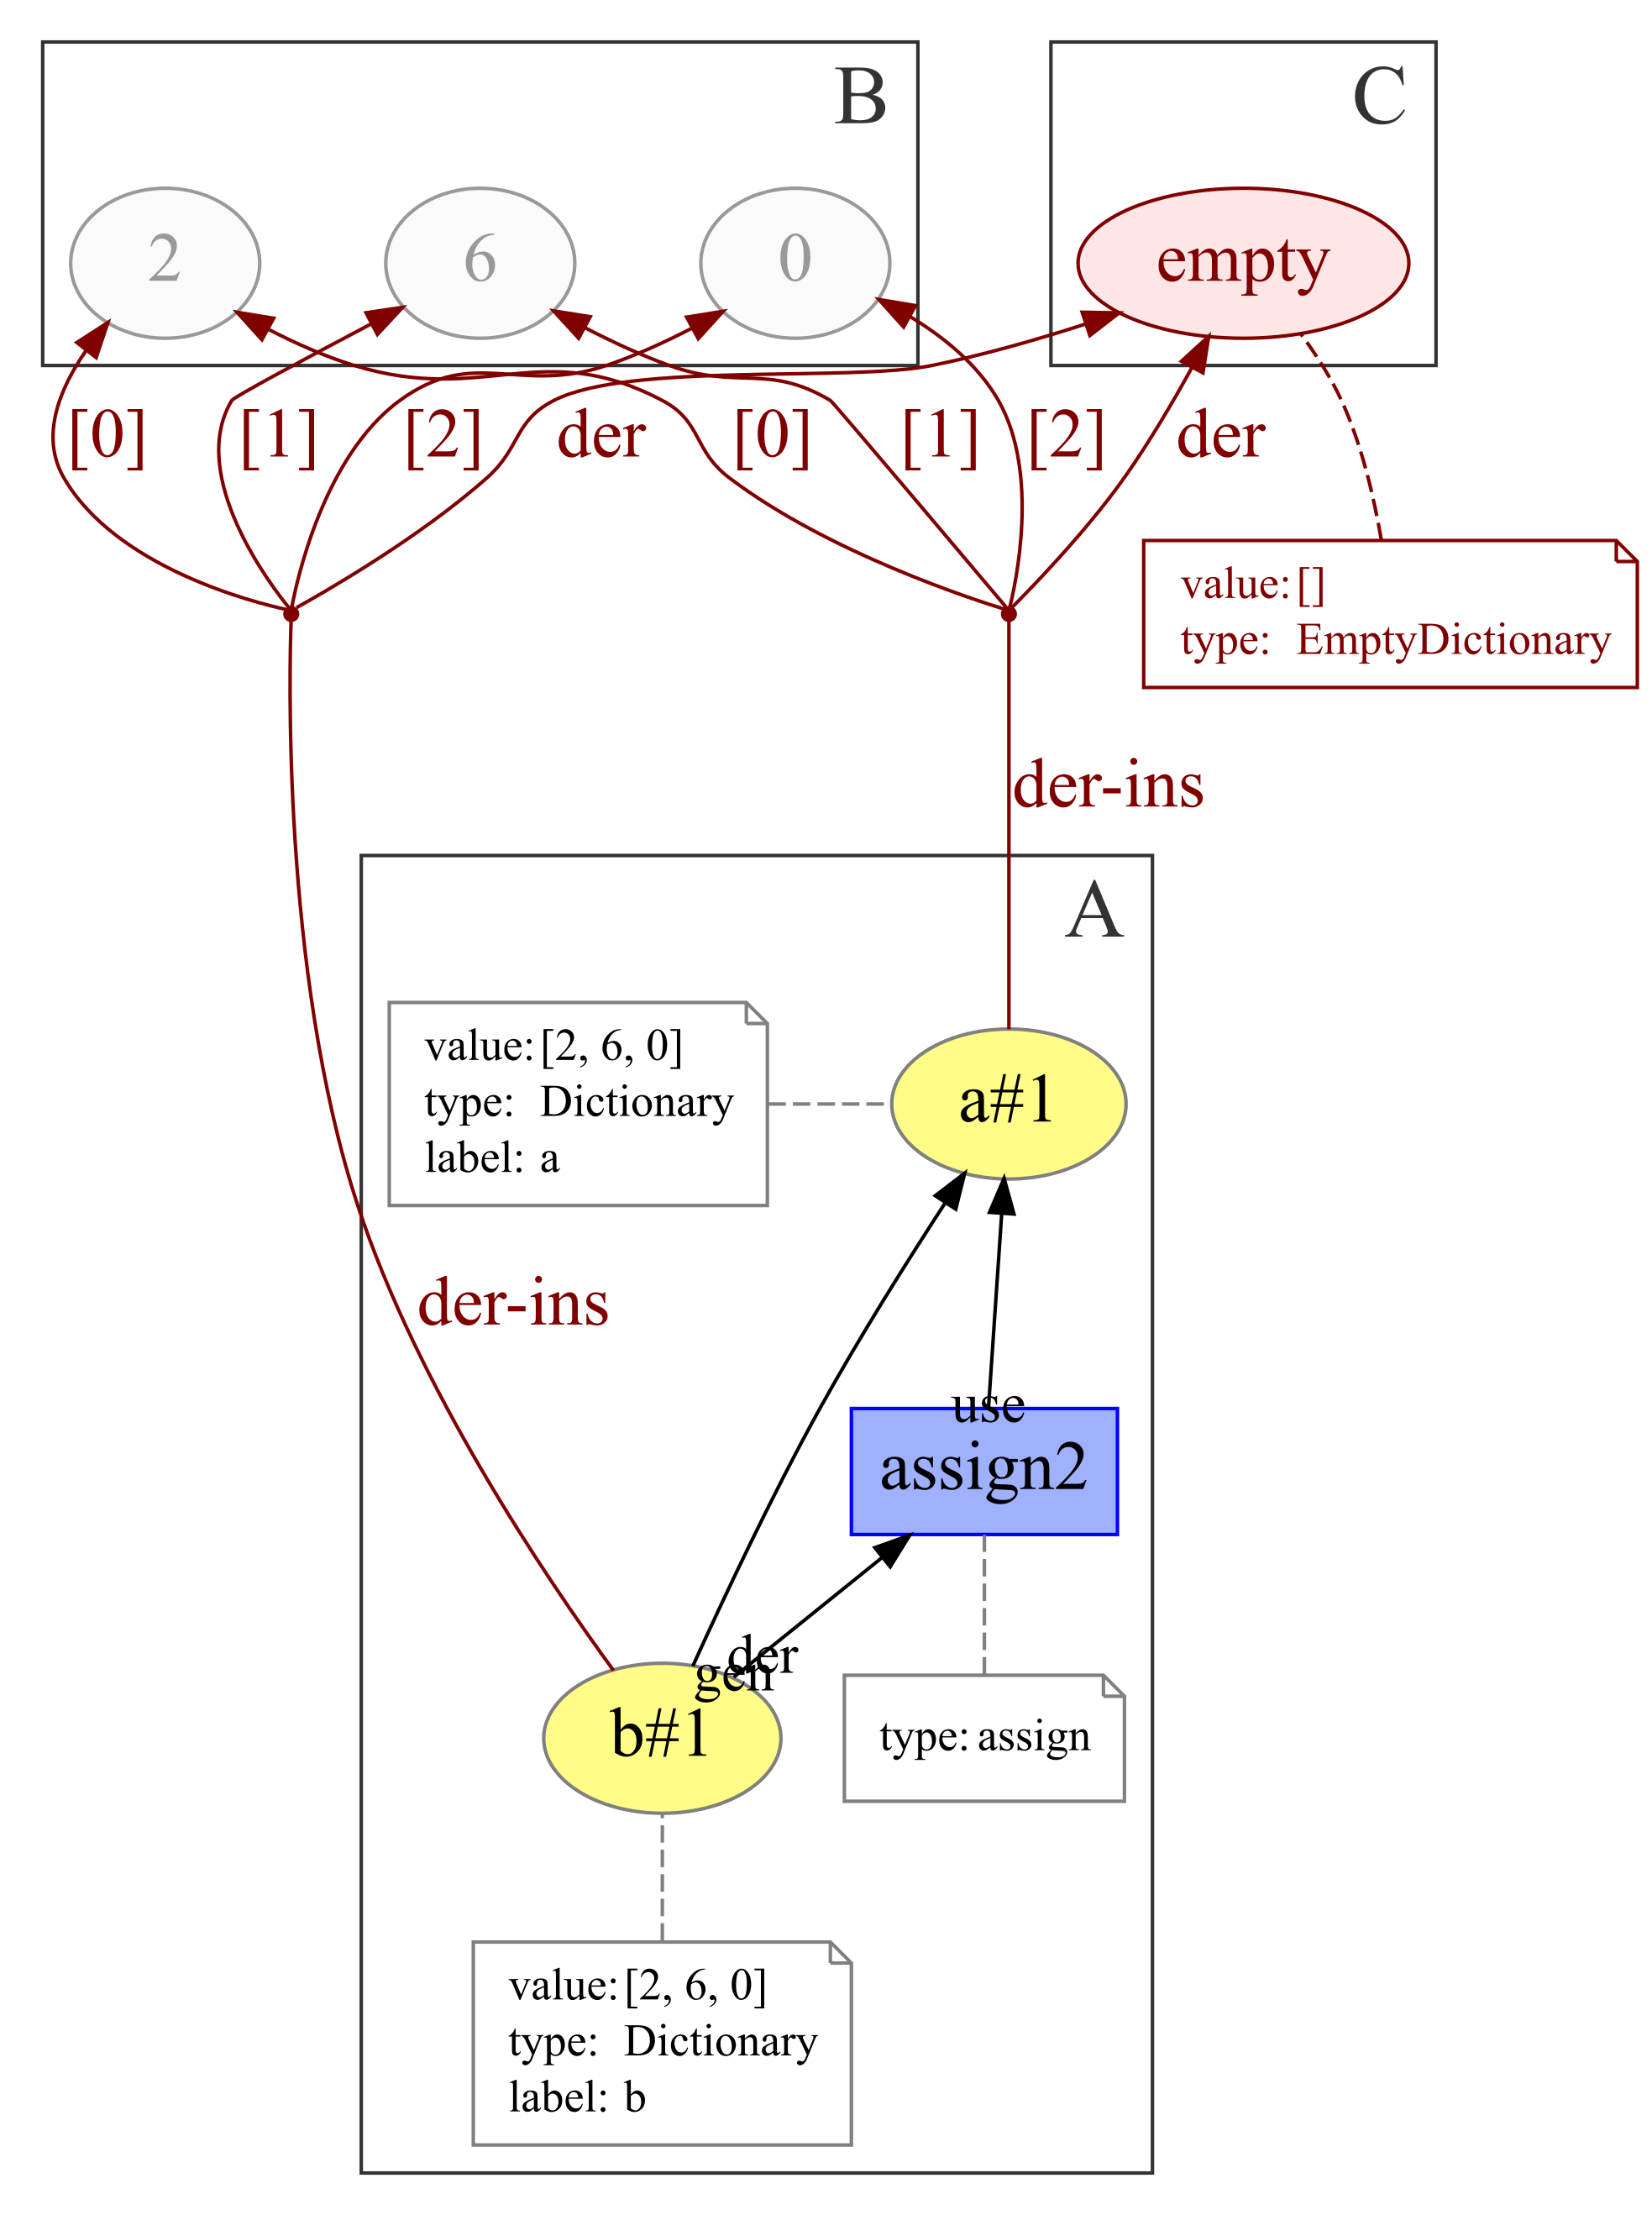

In [16]:
%%prov $BASE/dictionary_p1
newrank=true;
splines = "spline"

subgraph cluster_0 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "A";
    "g/a#1";
    "g/b#1"; "g/assign2"
    "g/a#1-attrs";
    "g/b#1-attrs"; "g/assign2-attrs"
    
}
subgraph cluster_1 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "B";
    "g/2"; "g/6";  "g/0"; 
}

subgraph cluster_2 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "C";
    "g/empty";
}
##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>

entity(empty, [value="[]", type="EmptyDictionary", dot:specific="true"])
entity(2, [value="2", type="script:literal", dot:hide2="true"])
entity(6, [value="6", type="script:literal", dot:hide2="true"])
entity(0, [value="0", type="script:literal", dot:hide2="true"])

entity(a#1, [value="[2, 6, 0]", type="Dictionary", label="a"])
entity(b#1, [value="[2, 6, 0]", type="Dictionary", label="b"])

derivedByInsertionFrom(
  a#1, empty, {
    ("0", 2),
    ("1", 6),
    ("2", 0)
}, [dot:specific="true"])

derivedByInsertionFrom(
  b#1, empty, {
    ("0", 2),
    ("1", 6),
    ("2", 0)
}, [dot:specific="true"])


activity(assign2, [type="script:assign"])
wasDerivedFrom(b#1, a#1, assign2, u2, g2, [dot:dist="2"])
used(u2; assign2, a#1, -, [dot:dist="0"])
wasGeneratedBy(g2; b#1, assign2, -, [dot:dist="0"])
endDocument
##F##
{rank=same "g/a#1" "g/a#1-attrs"}
{rank=same "g/2" "g/6" "g/0"}
"g/0" -> "g/6" -> "g/2" [style=invis]


DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:1536:840 exported to 4800 x 2625 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/dictionary_p2.png


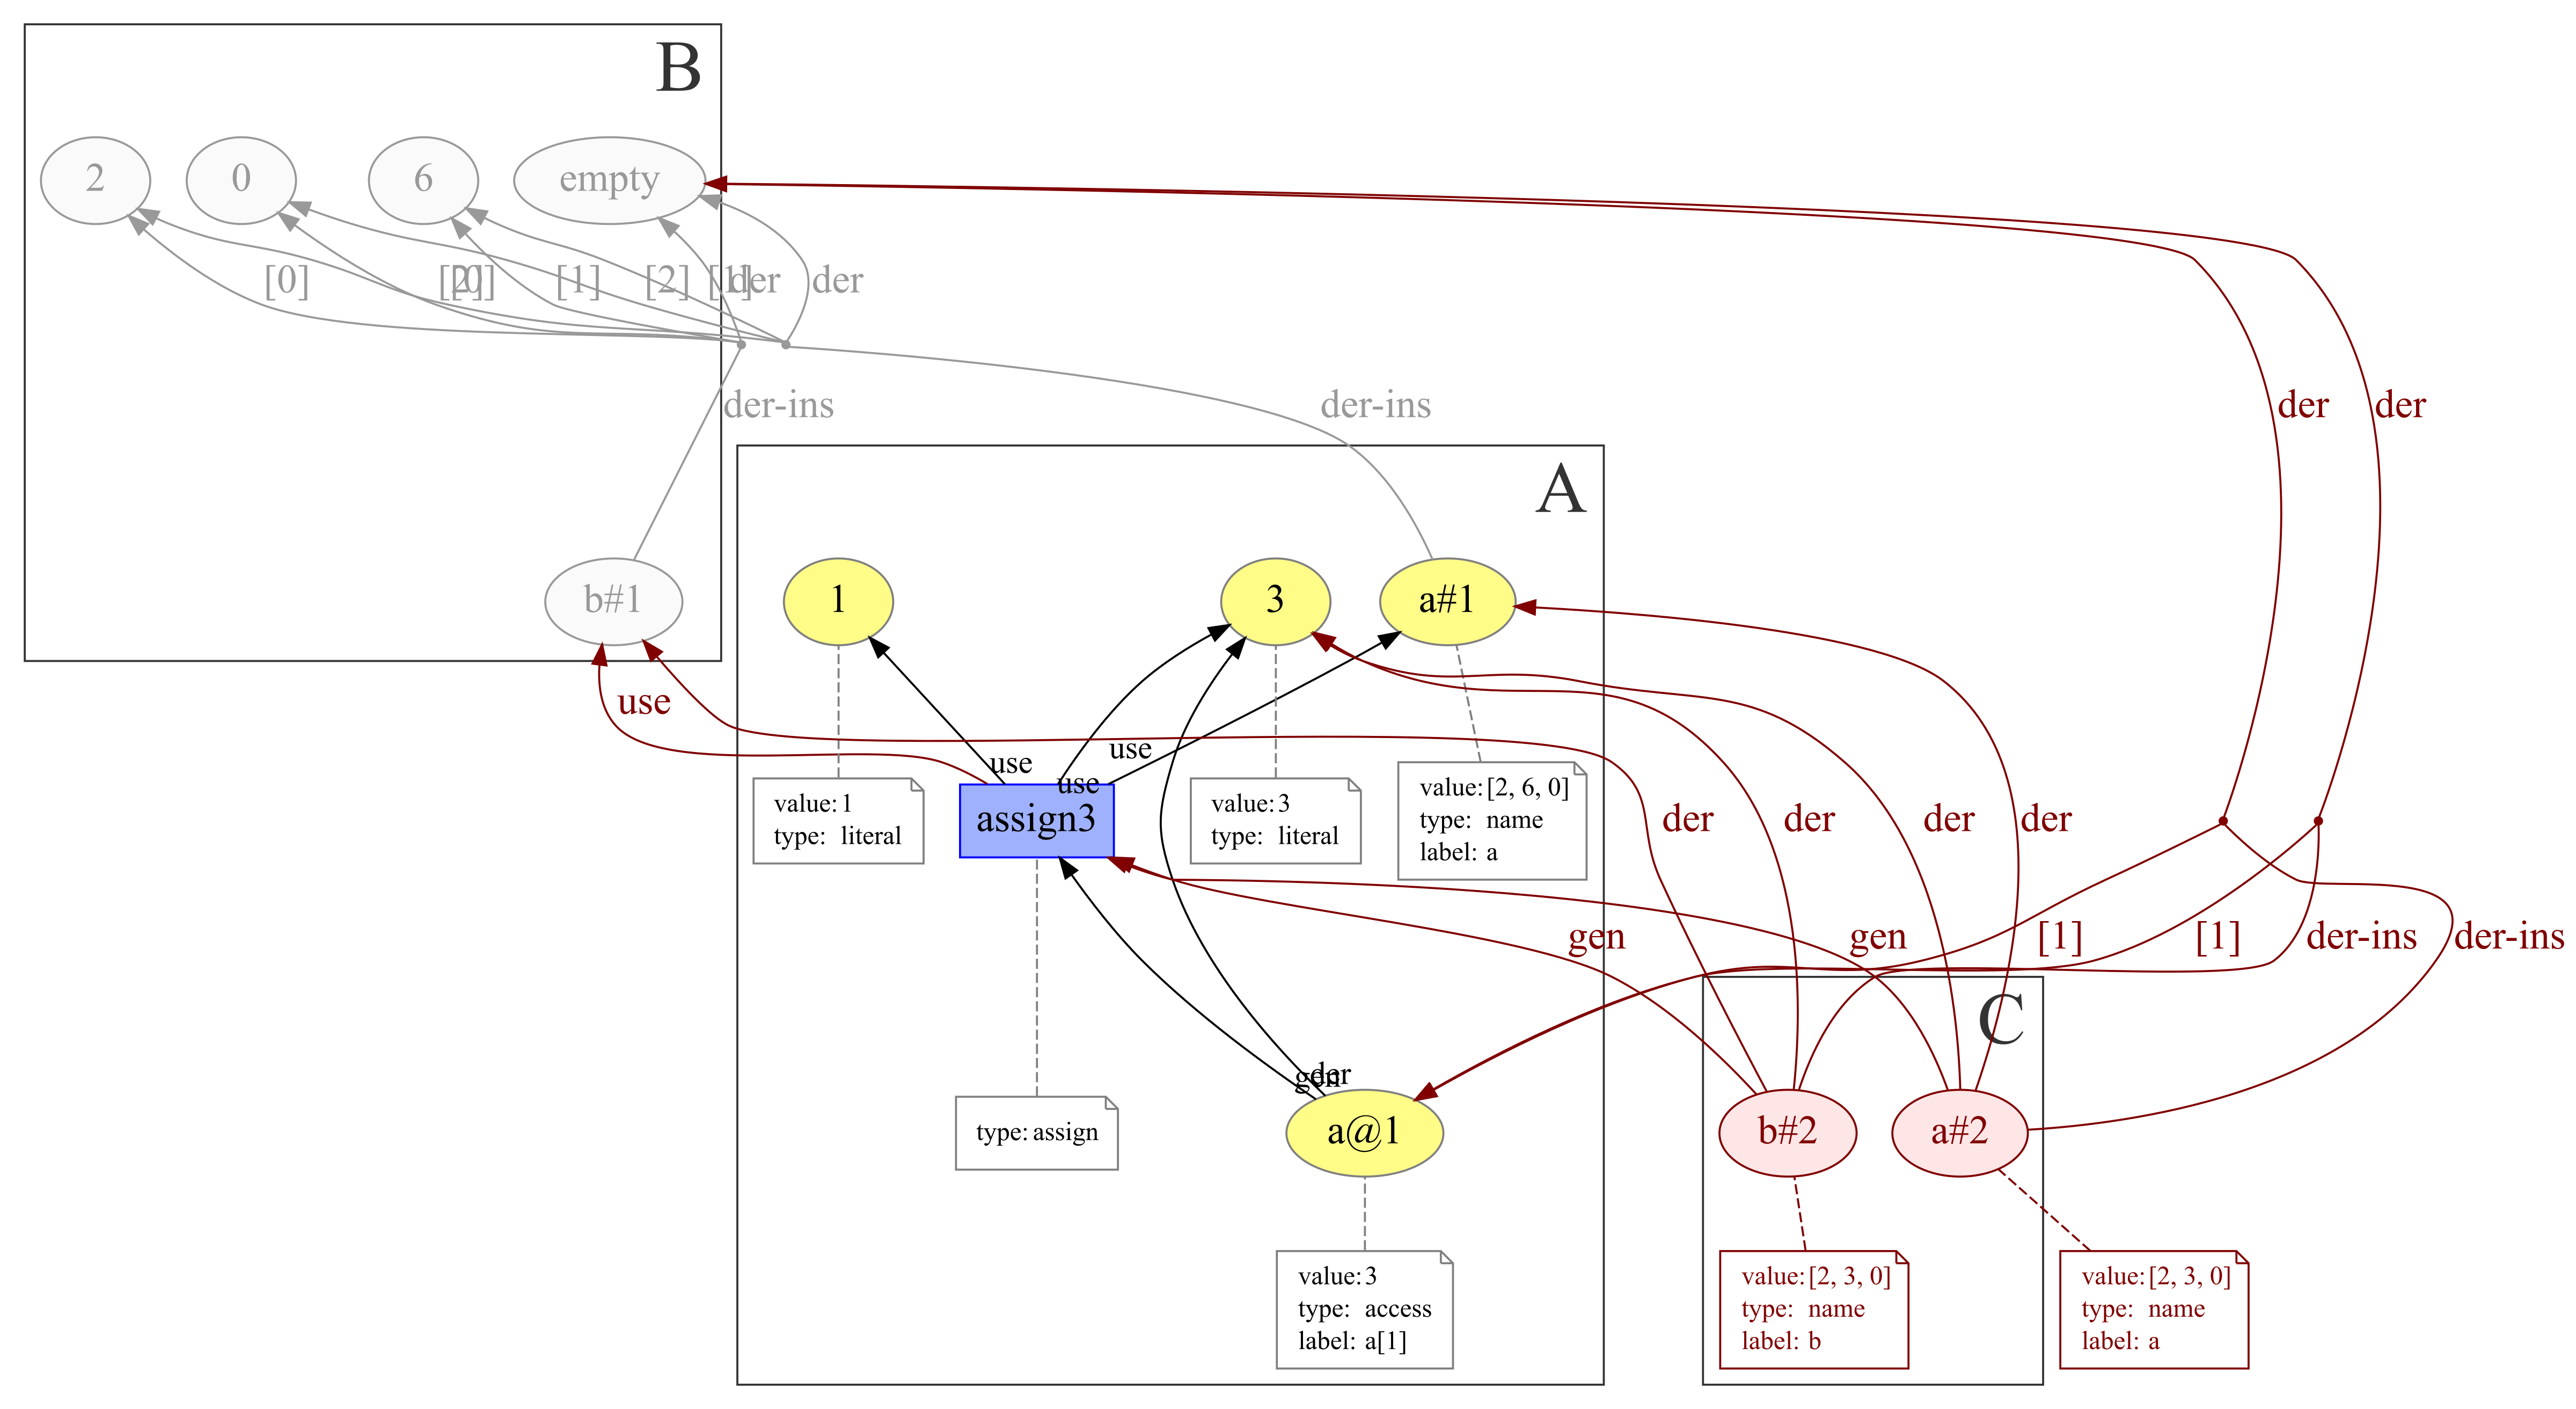

In [17]:
%%prov $BASE/dictionary_p2
newrank=true;
splines = "spline"

subgraph cluster_0 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "36"
    label = "A";
    "g/a@1"; "g/1"; "g/3"
    "g/a#1"; "g/assign3"
    
    "g/a@1-attrs"; "g/1-attrs"; "g/3-attrs"
    "g/a#1-attrs"; "g/assign3-attrs"
    
    
}
subgraph cluster_1 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "36"
    label = "B";
    "g/2"; "g/6"; "g/0"; "g/b#1"; "g/empty"
}

subgraph cluster_2 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "36"
    label = "C";
    "g/a#2";
    "g/b#2"; "g/b#2-attrs" 
}

##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>

entity(empty, [value="[]", type="EmptyDictionary", dot:hide2="true"])
entity(2, [value="2", type="script:literal", dot:hide2="true"])
entity(6, [value="6", type="script:literal", dot:hide2="true"])
entity(0, [value="0", type="script:literal", dot:hide2="true"])
entity(a#1, [value="[2, 6, 0]", type="script:name", label="a"])
entity(b#1, [value="[2, 6, 0]", type="script:name", label="b", dot:hide2="true"])
entity(3, [value="3", type="script:literal"])
entity(1, [value="1", type="script:literal"])
entity(a#2, [value="[2, 3, 0]", type="script:name", label="a", dot:specific="true"])
entity(b#2, [value="[2, 3, 0]", type="script:name", label="b", dot:specific="true"])

       
       
entity(a@1, [value="3", type="script:access", label="a[1]"])
       
derivedByInsertionFrom(
  a#1, empty, {
    ("0", 2),
    ("1", 6),
    ("2", 0)
}, [dot:hide2="true"])

derivedByInsertionFrom(
  b#1, empty, {
    ("0", 2),
    ("1", 6),
    ("2", 0)
}, [dot:hide2="true"])

derivedByInsertionFrom(
  a#2, empty, {
    ("1", a@1)
}, [dot:specific="true"])

derivedByInsertionFrom(
  b#2, empty, {
    ("1", a@1)
}, [dot:specific="true"])

activity(assign3, [type="script:assign"])
wasDerivedFrom(a#2, a#1, assign3, g4, u4, [dot:specific="true"])
wasDerivedFrom(a#2, 3, assign3, g4, u4, [dot:specific="true", dot:dist="0.5", dot:angle="270.0"])
used(u4; assign3, a#1, -, [dot:dist="2", dot:angle="-30.0"])
wasGeneratedBy(g4; a#2, assign3, -, [dot:specific="true", dot:dist="1", dot:angle="270.0"])
wasDerivedFrom(b#2, b#1, assign3, g6, u6, [dot:specific="true"])
wasDerivedFrom(b#2, 3, assign3, g6, u5, [dot:specific="true"])
wasDerivedFrom(a@1, 3, assign3, g5, u5)

used(assign3, 1, -)
endDocument
##F##
{rank=same "g/2" "g/6" "g/0"}
{rank=same "g/a@1" "g/a#2" "g/b#2"}
//{rank=same "g/a#1" "g/a#1-attrs"}
{rank=same "g/1" "g/3"}
"g/0" -> "g/6" -> "g/2" [style=invis]
"g/1" -> "g/2" [style=invis]
//"g/2" -> "g/3" [style=invis]
"g/a#2" -> "g/6" [style=invis]
//"g/b#2" -> "g/6" [style=invis]
